In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score
import lightgbm as lgbm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, precision_recall_curve
import random
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.base import clone
from lightgbm import LGBMClassifier
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import joblib
from scipy import stats
import pickle
import json
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

## Ant Colony Optimize

In [10]:
class ImprovedACOFeatureSelection:
    """
    Improved Ant Colony Optimization for Feature Selection with LGBM
    """
    
    def __init__(self, n_features, n_ants=10, max_iter=20, alpha=1, beta=2, 
                 rho=0.5, min_features=5, max_features=None):
        self.n_features = n_features
        self.n_ants = n_ants
        self.max_iter = max_iter
        self.alpha = alpha  # pheromone importance
        self.beta = beta    # heuristic importance
        self.rho = rho      # pheromone evaporation rate
        self.min_features = min_features
        self.max_features = max_features or n_features // 2

        # Initialize pheromone matrix for feature selection
        self.pheromone = np.ones(n_features) * 0.1
        self.best_subset = None
        self.best_score = -np.inf  # Maximize accuracy score
        self.best_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}
        self.history = []
        self.feature_heuristics = None

    def _calculate_heuristics(self, X, y):
        """Calculate heuristic information for each feature"""
        from sklearn.feature_selection import mutual_info_classif
        from sklearn.preprocessing import LabelEncoder
        
        # Handle categorical target if needed
        if y.dtype == 'object':
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
        else:
            y_encoded = y
            
        # Calculate mutual information
        mi_scores = mutual_info_classif(X, y_encoded, random_state=42)
        
        # Normalize to [0.1, 1] range
        mi_scores = mi_scores / (mi_scores.max() + 1e-10)
        mi_scores = mi_scores * 0.9 + 0.1  # Scale to [0.1, 1]
        
        return mi_scores

    def _evaluate_subset_detailed(self, X, y, feature_subset, cv_folds=3):
        """Evaluate feature subset with detailed metrics using cross-validation"""
        if len(feature_subset) == 0:
            return {'accuracy': -np.inf, 'precision': 0, 'recall': 0, 'f1': 0}
            
        X_subset = X.iloc[:, feature_subset] if hasattr(X, 'iloc') else X[:, feature_subset]
        
        # LGBM parameters
        lgb_params = {
            'objective': 'multiclass' if len(np.unique(y)) > 2 else 'binary',
            'num_class': len(np.unique(y)) if len(np.unique(y)) > 2 else None,
            'metric': 'multi_logloss' if len(np.unique(y)) > 2 else 'binary_logloss',
            'verbosity': -1,
            'random_state': 42,
            'n_estimators': 100,
            'learning_rate': 0.1
        }
        
        try:
            # Use stratified k-fold for better evaluation
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            model = lgb.LGBMClassifier(**lgb_params)
            
            # Calculate different metrics
            scoring_methods = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
            results = {}
            
            for scoring in scoring_methods:
                scores = cross_val_score(model, X_subset, y, cv=cv, scoring=scoring)
                metric_name = scoring.replace('_macro', '')
                results[metric_name] = scores.mean()
            
            return results
            
        except Exception as e:
            print(f"Error evaluating subset: {e}")
            return {'accuracy': -np.inf, 'precision': 0, 'recall': 0, 'f1': 0}

    def _construct_solution(self, ant_id):
        """Construct a solution (feature subset) for one ant"""
        selected_features = []
        available_features = list(range(self.n_features))
        
        # Randomly select number of features within bounds
        n_select = random.randint(self.min_features, 
                                min(self.max_features, self.n_features))
        
        for _ in range(n_select):
            if not available_features:
                break
                
            # Calculate selection probabilities
            probabilities = []
            for feature in available_features:
                pheromone = self.pheromone[feature]
                heuristic = self.feature_heuristics[feature]
                prob = (pheromone ** self.alpha) * (heuristic ** self.beta)
                probabilities.append(prob)
            
            # Normalize probabilities
            probabilities = np.array(probabilities)
            probabilities = probabilities / (probabilities.sum() + 1e-10)
            
            # Roulette wheel selection
            selected_idx = np.random.choice(len(available_features), p=probabilities)
            selected_feature = available_features[selected_idx]
            
            selected_features.append(selected_feature)
            available_features.remove(selected_feature)
        
        return selected_features

    def _update_pheromone(self, all_subsets, all_scores):
        """Update pheromone trails"""
        # Evaporation
        self.pheromone *= (1 - self.rho)
        
        # Find best solutions in this iteration
        sorted_indices = np.argsort(all_scores)[::-1]  # Descending order
        n_elite = max(1, len(all_scores) // 4)  # Top 25% solutions
        
        # Deposit pheromone for elite solutions
        for i in range(n_elite):
            idx = sorted_indices[i]
            subset = all_subsets[idx]
            score = all_scores[idx]
            
            # Amount of pheromone to deposit (normalized score)
            if score > 0:
                delta_pheromone = score * (n_elite - i) / n_elite  # Weight by rank
                
                for feature in subset:
                    self.pheromone[feature] += delta_pheromone

        # Ensure minimum pheromone level
        self.pheromone = np.clip(self.pheromone, 0.001, 10.0)

    def fit(self, X, y, validation_split=0.2):
        """
        Fit ACO feature selection
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        validation_split : float
            Fraction of data to use for validation
        """
        # Split data into train and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42, 
            stratify=y if len(np.unique(y)) > 1 else None
        )
        
        # Calculate heuristic information
        print("Calculating feature heuristics...")
        self.feature_heuristics = self._calculate_heuristics(X_train, y_train)
        
        print(f"Starting ACO optimization with {self.n_ants} ants for {self.max_iter} iterations...")
        
        for iteration in range(self.max_iter):
            all_subsets = []
            all_scores = []
            
            # Each ant constructs a solution
            for ant in range(self.n_ants):
                subset = self._construct_solution(ant)
                metrics = self._evaluate_subset_detailed(X_train, y_train, subset)
                score = metrics['accuracy']  # Primary optimization metric
                
                all_subsets.append(subset)
                all_scores.append(score)
                
                # Update global best
                if score > self.best_score:
                    self.best_score = score
                    self.best_subset = subset.copy()
                    self.best_metrics = metrics.copy()
            
            # Update pheromone
            self._update_pheromone(all_subsets, all_scores)
            
            # Validation metrics for best subset
            val_metrics = self._evaluate_subset_detailed(X_val, y_val, self.best_subset)
            
            # Record detailed history - KEEP ALL ORIGINAL TRACKING
            self.history.append({
                'iteration': iteration + 1,
                'train_accuracy': self.best_metrics['accuracy'],
                'train_precision': self.best_metrics['precision'],
                'train_recall': self.best_metrics['recall'],
                'train_f1': self.best_metrics['f1'],
                'val_accuracy': val_metrics['accuracy'],
                'val_precision': val_metrics['precision'],
                'val_recall': val_metrics['recall'],
                'val_f1': val_metrics['f1'],
                'n_features': len(self.best_subset),
                'avg_accuracy': np.mean(all_scores)
            })
            
            print(f"Iter {iteration+1:2d}/{self.max_iter}: "
                  f"Train Acc: {self.best_metrics['accuracy']:.4f}, "
                  f"Val Acc: {val_metrics['accuracy']:.4f}, "
                  f"Val F1: {val_metrics['f1']:.4f}, "
                  f"Features: {len(self.best_subset)}")

        return self.best_subset

    def plot_convergence(self):
        """Plot optimization convergence with reduced charts"""
        if not self.history:
            print("No history available for plotting")
            return
            
        # Set style for better looking plots
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(12, 8))
        
        iterations = [h['iteration'] for h in self.history]
        
        # Plot 1: Accuracy comparison (KEEP)
        plt.subplot(2, 2, 1)
        train_acc = [h['train_accuracy'] for h in self.history]
        val_acc = [h['val_accuracy'] for h in self.history]
        avg_acc = [h['avg_accuracy'] for h in self.history]
        
        plt.plot(iterations, train_acc, 'b-o', label='Best Train Accuracy', linewidth=2)
        plt.plot(iterations, val_acc, 'r-s', label='Validation Accuracy', linewidth=2)
        plt.plot(iterations, avg_acc, 'g--', label='Average Accuracy', alpha=0.7)
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Evolution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # REMOVED: Precision comparison
        # REMOVED: Recall comparison  
        # REMOVED: F1-Score comparison
        # REMOVED: Number of features
        # REMOVED: All metrics combined on validation set
        
        # Plot 2: Pheromone levels (from plot_detailed_analysis)
        plt.subplot(2, 2, 2)
        all_features = np.arange(len(self.pheromone))
        colors = ['red' if i in self.best_subset else 'lightblue' for i in all_features]
        bars = plt.bar(all_features, self.pheromone, color=colors)
        plt.xlabel('Feature Index')
        plt.ylabel('Pheromone Level')
        plt.title('Pheromone Distribution\n(Red = Selected Features)')
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Heuristic values (from plot_detailed_analysis)
        plt.subplot(2, 2, 3)
        colors = ['red' if i in self.best_subset else 'lightgreen' for i in all_features]
        bars = plt.bar(all_features, self.feature_heuristics, color=colors)
        plt.xlabel('Feature Index')
        plt.ylabel('Heuristic Value (MI Score)')
        plt.title('Feature Heuristics\n(Red = Selected Features)')
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Combined importance for selected features (from plot_detailed_analysis)
        plt.subplot(2, 2, 4)
        if self.best_subset:
            selected_importance = [(i, self.pheromone[i] * self.feature_heuristics[i]) 
                                 for i in self.best_subset]
            selected_importance.sort(key=lambda x: x[1], reverse=True)
            
            indices, importances = zip(*selected_importance)
            feature_labels = [f'F{i}' for i in indices]
            
            plt.barh(range(len(indices)), importances, color='orange')
            plt.yticks(range(len(indices)), feature_labels)
            plt.xlabel('Importance Score')
            plt.title('Selected Feature Importance')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def plot_detailed_analysis(self, feature_names=None):
        """Plot detailed analysis - KEEP original but remove unwanted charts"""
        if not self.history or not self.best_subset:
            print("No data available for detailed analysis")
            return
            
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(12, 8))
        
        # Plot 1: Metrics correlation heatmap (final iteration) - KEEP
        plt.subplot(2, 2, 1)
        final_metrics = self.history[-1]
        metrics_data = {
            'Train': [final_metrics['train_accuracy'], final_metrics['train_precision'], 
                     final_metrics['train_recall'], final_metrics['train_f1']],
            'Validation': [final_metrics['val_accuracy'], final_metrics['val_precision'],
                          final_metrics['val_recall'], final_metrics['val_f1']]
        }
        
        df_metrics = pd.DataFrame(metrics_data, 
                                 index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
        
        sns.heatmap(df_metrics, annot=True, cmap='RdYlBu_r', center=0.5, 
                   fmt='.3f', cbar_kws={'label': 'Score'})
        plt.title('Final Metrics Comparison')
        
        # REMOVED: Pheromone levels (moved to plot_convergence)
        # REMOVED: Heuristic values (moved to plot_convergence)
        # REMOVED: Combined importance (moved to plot_convergence)
        # REMOVED: Feature selection stability
        # REMOVED: Performance improvement over iterations
        
        # Plot 2: Feature importance with names if available
        plt.subplot(2, 2, 2)
        if self.best_subset:
            selected_importance = [(i, self.pheromone[i] * self.feature_heuristics[i]) 
                                 for i in self.best_subset]
            selected_importance.sort(key=lambda x: x[1], reverse=True)
            
            indices, importances = zip(*selected_importance)
            feature_labels = [feature_names[i] if feature_names and i < len(feature_names) else f'F{i}' for i in indices]
            
            # Show top 10 features if more than 10
            if len(indices) > 10:
                indices = indices[:10]
                importances = importances[:10]
                feature_labels = feature_labels[:10]
            
            plt.barh(range(len(indices)), importances, color='orange')
            plt.yticks(range(len(indices)), feature_labels)
            plt.xlabel('Importance Score')
            plt.title('Top Selected Feature Importance')
            plt.grid(True, alpha=0.3)
        
        # Plot 3: Training progress
        plt.subplot(2, 2, 3)
        iterations = [h['iteration'] for h in self.history]
        val_acc = [h['val_accuracy'] for h in self.history]
        train_acc = [h['train_accuracy'] for h in self.history]
        
        plt.plot(iterations, train_acc, 'b-o', label='Training Accuracy', linewidth=2)
        plt.plot(iterations, val_acc, 'r-s', label='Validation Accuracy', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Feature count over iterations
        plt.subplot(2, 2, 4)
        n_features = [h['n_features'] for h in self.history]
        plt.plot(iterations, n_features, 'purple', marker='o', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Number of Features')
        plt.title('Feature Count Evolution')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def get_selected_features(self, feature_names=None):
        """Get selected features with their importance"""
        if not self.best_subset:
            return {}
            
        result = {}
        for i, feature_idx in enumerate(self.best_subset):
            importance = self.pheromone[feature_idx] * self.feature_heuristics[feature_idx]
            
            if feature_names and feature_idx < len(feature_names):
                result[feature_names[feature_idx]] = {
                    'index': feature_idx,
                    'importance': importance,
                    'pheromone': self.pheromone[feature_idx],
                    'heuristic': self.feature_heuristics[feature_idx]
                }
            else:
                result[f'feature_{feature_idx}'] = {
                    'index': feature_idx,
                    'importance': importance,
                    'pheromone': self.pheromone[feature_idx],
                    'heuristic': self.feature_heuristics[feature_idx]
                }
                
        return result


def run_lgbm_feature_selection(data_path, target_column='group', 
                              n_ants=15, max_iter=20):
    """
    Run ACO feature selection specifically for LGBM on full dataset
    """
    # Load data
    print(f"Loading data from {data_path}...")
    data = pd.read_csv(data_path)
    
    print(f"Full dataset shape: {data.shape}")
    print(f"Loading complete - using entire dataset with {len(data)} samples")
    
    # Prepare features and target
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    feature_names = X.columns.tolist()
    
    print(f"Number of features: {len(feature_names)}")
    print(f"Target classes: {y.unique()}")
    
    # Baseline evaluation with all features
    print("\n=== Baseline (All Features) ===")
    lgb_model = lgb.LGBMClassifier(random_state=42, verbosity=-1)
    
    # Calculate multiple metrics for baseline
    baseline_accuracy = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy').mean()
    baseline_precision = cross_val_score(lgb_model, X, y, cv=5, scoring='precision_macro').mean()
    baseline_recall = cross_val_score(lgb_model, X, y, cv=5, scoring='recall_macro').mean()
    baseline_f1 = cross_val_score(lgb_model, X, y, cv=5, scoring='f1_macro').mean()
    
    baseline_metrics = {
        'accuracy': baseline_accuracy,
        'precision': baseline_precision,
        'recall': baseline_recall,
        'f1': baseline_f1
    }
    
    print(f"Baseline Accuracy:  {baseline_accuracy:.4f}")
    print(f"Baseline Precision: {baseline_precision:.4f}")
    print(f"Baseline Recall:    {baseline_recall:.4f}")
    print(f"Baseline F1-Score:  {baseline_f1:.4f}")
    
    # ACO Feature Selection
    print("\n=== ACO Feature Selection ===")
    start_time = time.time()
    
    aco = ImprovedACOFeatureSelection(
        n_features=len(feature_names),
        n_ants=n_ants,
        max_iter=max_iter,
        alpha=1.0,
        beta=2.0,
        rho=0.1,
        min_features=5,
        max_features=min(30, len(feature_names)//2)
    )
    
    selected_indices = aco.fit(X, y)
    elapsed_time = time.time() - start_time
    
    print(f"\nOptimization completed in {elapsed_time:.2f} seconds")
    
    # Evaluate selected features with detailed metrics
    print("\n=== Selected Features Evaluation ===")
    X_selected = X.iloc[:, selected_indices]
    
    selected_accuracy = cross_val_score(lgb_model, X_selected, y, cv=5, scoring='accuracy').mean()
    selected_precision = cross_val_score(lgb_model, X_selected, y, cv=5, scoring='precision_macro').mean()
    selected_recall = cross_val_score(lgb_model, X_selected, y, cv=5, scoring='recall_macro').mean()
    selected_f1 = cross_val_score(lgb_model, X_selected, y, cv=5, scoring='f1_macro').mean()
    
    selected_metrics = {
        'accuracy': selected_accuracy,
        'precision': selected_precision,
        'recall': selected_recall,
        'f1': selected_f1
    }
    
    print(f"Selected Accuracy:  {selected_accuracy:.4f}")
    print(f"Selected Precision: {selected_precision:.4f}")
    print(f"Selected Recall:    {selected_recall:.4f}")
    print(f"Selected F1-Score:  {selected_f1:.4f}")
    print(f"Feature reduction: {len(feature_names)} -> {len(selected_indices)} "
          f"({100*(1-len(selected_indices)/len(feature_names)):.1f}% reduction)")
    
    # Show selected features
    selected_features = aco.get_selected_features(feature_names)
    print(f"\nSelected Features ({len(selected_features)}):")
    
    # Sort by importance
    sorted_features = sorted(selected_features.items(), 
                           key=lambda x: x[1]['importance'], reverse=True)
    
    for i, (name, info) in enumerate(sorted_features[:10]):  # Top 10
        print(f"{i+1:2d}. {name:20s} (importance: {info['importance']:.3f})")
    
    if len(sorted_features) > 10:
        print(f"    ... and {len(sorted_features)-10} more features")
    
    # Plot results with detailed analysis
    print("\n=== Generating Visualizations ===")
    aco.plot_convergence()
    aco.plot_detailed_analysis(feature_names)
    
    # Create comparison plot - KEEP ORIGINAL
    plt.figure(figsize=(12, 8))
    
    # Comparison bar plot
    plt.subplot(2, 2, 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    baseline_values = [baseline_metrics['accuracy'], baseline_metrics['precision'], 
                      baseline_metrics['recall'], baseline_metrics['f1']]
    selected_values = [selected_metrics['accuracy'], selected_metrics['precision'],
                      selected_metrics['recall'], selected_metrics['f1']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, baseline_values, width, label='All Features', color='lightblue')
    plt.bar(x + width/2, selected_values, width, label='Selected Features', color='orange')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Performance Comparison: All vs Selected Features')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Feature count comparison
    plt.subplot(2, 2, 2)
    categories = ['All Features', 'Selected Features']
    counts = [len(feature_names), len(selected_indices)]
    colors = ['lightcoral', 'lightgreen']
    
    bars = plt.bar(categories, counts, color=colors)
    plt.ylabel('Number of Features')
    plt.title('Feature Count Comparison')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    # Improvement/degradation plot
    plt.subplot(2, 2, 3)
    improvements = [selected_values[i] - baseline_values[i] for i in range(len(metrics))]
    colors = ['green' if x >= 0 else 'red' for x in improvements]
    
    bars = plt.bar(metrics, improvements, color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.ylabel('Performance Change')
    plt.title('Performance Change (Selected - All)')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar, imp in zip(bars, improvements):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.001 if imp >= 0 else -0.001),
                f'{imp:+.3f}', ha='center', va='bottom' if imp >= 0 else 'top')
    
    plt.grid(True, alpha=0.3)
    
    # Feature reduction visualization
    plt.subplot(2, 2, 4)
    reduction_pct = 100 * (1 - len(selected_indices) / len(feature_names))
    remaining_pct = 100 - reduction_pct
    
    sizes = [remaining_pct, reduction_pct]
    labels = [f'Selected\n({len(selected_indices)} features)', 
              f'Removed\n({len(feature_names) - len(selected_indices)} features)']
    colors = ['lightgreen', 'lightcoral']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Feature Selection Results')
    
    plt.tight_layout()
    plt.show()
    
    # Summary with detailed metrics comparison - KEEP ORIGINAL
    print("\n" + "="*80)
    print("DETAILED PERFORMANCE SUMMARY")
    print("="*80)
    
    print(f"{'Metric':<15} {'All Features':<15} {'Selected':<15} {'Change':<15} {'% Change':<15}")
    print("-" * 75)
    
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        baseline_val = baseline_metrics[metric]
        selected_val = selected_metrics[metric]
        change = selected_val - baseline_val
        pct_change = (change / baseline_val) * 100
        
        print(f"{metric.capitalize():<15} {baseline_val:<15.4f} {selected_val:<15.4f} "
              f"{change:<+15.4f} {pct_change:<+15.2f}%")
    
    print("-" * 75)
    print(f"{'Features':<15} {len(feature_names):<15d} {len(selected_indices):<15d} "
          f"{len(selected_indices) - len(feature_names):<+15d} "
          f"{100*(len(selected_indices)/len(feature_names) - 1):<+15.1f}%")
    
    # Overall assessment - KEEP ORIGINAL
    print("\nOVERALL ASSESSMENT:")
    accuracy_improvement = selected_metrics['accuracy'] - baseline_metrics['accuracy']
    feature_reduction = 100 * (1 - len(selected_indices) / len(feature_names))
    
    if accuracy_improvement >= 0:
        print(f"‚úì Accuracy maintained/improved: {accuracy_improvement:+.4f}")
    else:
        print(f"‚ö† Accuracy decreased: {accuracy_improvement:+.4f}")
    
    print(f"‚úì Feature reduction achieved: {feature_reduction:.1f}%")
    
    if accuracy_improvement >= -0.01 and feature_reduction > 10:
        print("üéØ SUCCESS: Significant feature reduction with minimal accuracy loss!")
    elif accuracy_improvement > 0.01:
        print("üéØ EXCELLENT: Feature reduction with accuracy improvement!")
    else:
        print("‚ö† REVIEW: Consider adjusting ACO parameters for better balance")

    return aco, selected_indices, X_selected, {
        'baseline_metrics': baseline_metrics,
        'selected_metrics': selected_metrics,
        'feature_reduction_pct': feature_reduction
    }

## Feature Selection: Compare RAW LGBM Vs ACO + LGBM

In [11]:
class DirectDataComparison:
    """
    Compare LGBM performance between two pre-processed datasets:
    - Raw data (health_data_proccess.csv)
    - ACO-processed data (health_data_ACO_ver2.csv)
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.results = {}
        self.models = {}
        self.training_times = {}
        self.data_info = {}
        
    def load_and_prepare_data(self, raw_data_path, aco_data_path, target_column='group', test_size=0.2):
        """
        Load both datasets and prepare train/test splits
        """
        print("=" * 80)
        print("LOADING AND PREPARING DATASETS")
        print("=" * 80)
        
        # Load raw data
        print(f"üìÇ Loading raw data from: {raw_data_path}")
        self.raw_data = pd.read_csv(raw_data_path)
        self.X_raw = self.raw_data.drop(target_column, axis=1)
        self.y_raw = self.raw_data[target_column]
        
        print(f"   ‚Ä¢ Raw data shape: {self.raw_data.shape}")
        print(f"   ‚Ä¢ Features: {self.X_raw.shape[1]}")
        print(f"   ‚Ä¢ Samples: {len(self.y_raw)}")
        
        # Load ACO-processed data
        print(f"\nüêú Loading ACO-processed data from: {aco_data_path}")
        self.aco_data = pd.read_csv(aco_data_path)
        self.X_aco = self.aco_data.drop(target_column, axis=1)
        self.y_aco = self.aco_data[target_column]
        
        print(f"   ‚Ä¢ ACO data shape: {self.aco_data.shape}")
        print(f"   ‚Ä¢ Features: {self.X_aco.shape[1]}")
        print(f"   ‚Ä¢ Samples: {len(self.y_aco)}")
        
        # Verify target consistency
        if not np.array_equal(self.y_raw.values, self.y_aco.values):
            print("‚ö†Ô∏è  WARNING: Target values are different between datasets!")
            print("   This might indicate data inconsistency.")
        else:
            print("‚úÖ Target values are consistent between datasets")
        
        # Store data information
        self.data_info = {
            'raw_features': self.X_raw.shape[1],
            'aco_features': self.X_aco.shape[1],
            'feature_reduction': self.X_raw.shape[1] - self.X_aco.shape[1],
            'feature_reduction_pct': 100 * (1 - self.X_aco.shape[1] / self.X_raw.shape[1]),
            'n_samples': len(self.y_raw),
            'target_classes': np.unique(self.y_raw),
            'n_classes': len(np.unique(self.y_raw))
        }
        
        print(f"\nüìä DATA SUMMARY:")
        print(f"   ‚Ä¢ Feature reduction: {self.data_info['raw_features']} ‚Üí {self.data_info['aco_features']} "
              f"({self.data_info['feature_reduction_pct']:.1f}% reduction)")
        print(f"   ‚Ä¢ Target classes: {self.data_info['target_classes']}")
        print(f"   ‚Ä¢ Class distribution:")
        
        for class_val in self.data_info['target_classes']:
            count = sum(self.y_raw == class_val)
            pct = 100 * count / len(self.y_raw)
            print(f"     - Class {class_val}: {count} samples ({pct:.1f}%)")
        
        # Create train/test splits with same indices for fair comparison
        print(f"\nüîÑ Creating train/test splits (test_size={test_size})...")
        
        # Split raw data
        self.X_raw_train, self.X_raw_test, self.y_train, self.y_test = train_test_split(
            self.X_raw, self.y_raw, test_size=test_size, random_state=self.random_state,
            stratify=self.y_raw if len(np.unique(self.y_raw)) > 1 else None
        )
        
        # Split ACO data using same indices
        self.X_aco_train = self.X_aco.iloc[self.X_raw_train.index]
        self.X_aco_test = self.X_aco.iloc[self.X_raw_test.index]
        
        print(f"   ‚Ä¢ Training samples: {len(self.X_raw_train)}")
        print(f"   ‚Ä¢ Test samples: {len(self.X_raw_test)}")
        print(f"   ‚Ä¢ Raw training features: {self.X_raw_train.shape[1]}")
        print(f"   ‚Ä¢ ACO training features: {self.X_aco_train.shape[1]}")
        
    def train_and_evaluate_model(self, X_train, X_test, y_train, y_test, model_name, 
                                hyperparameter_tuning=True):
        """
        Train and evaluate LGBM model with comprehensive metrics
        """
        print(f"\n{'=' * 60}")
        print(f"TRAINING {model_name.upper()} MODEL")
        print(f"{'=' * 60}")
        
        # Base LGBM parameters
        base_params = {
            'objective': 'multiclass' if self.data_info['n_classes'] > 2 else 'binary',
            'num_class': self.data_info['n_classes'] if self.data_info['n_classes'] > 2 else None,
            'metric': 'multi_logloss' if self.data_info['n_classes'] > 2 else 'binary_logloss',
            'verbosity': -1,
            'random_state': self.random_state,
            'n_jobs': -1
        }
        
        # Hyperparameter tuning
        tuning_start_time = time.time()
        
        if hyperparameter_tuning:
            print(f"üîß Performing hyperparameter tuning...")
            
            # Adaptive parameter grid based on dataset size
            n_samples = len(X_train)
            if n_samples < 1000:
                param_grid = {
                    'n_estimators': [50, 100, 150],
                    'learning_rate': [0.05, 0.1],
                    'num_leaves': [31, 50],
                    'max_depth': [-1, 10]
                }
            else:
                param_grid = {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.15],
                    'num_leaves': [31, 50, 100],
                    'max_depth': [-1, 10, 20],
                    'min_child_samples': [20, 30, 50]
                }
            
            lgb_model = lgb.LGBMClassifier(**base_params)
            
            # Grid search with cross-validation
            grid_search = GridSearchCV(
                lgb_model, param_grid, cv=3, scoring='accuracy',
                n_jobs=-1, verbose=0
            )
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            print(f"   ‚úÖ Best parameters found: {grid_search.best_params_}")
            print(f"   ‚úÖ Best CV score: {grid_search.best_score_:.4f}")
            
        else:
            print(f"‚ö° Using default parameters (faster training)...")
            best_model = lgb.LGBMClassifier(
                n_estimators=200,
                learning_rate=0.1,
                **base_params
            )
        
        tuning_time = time.time() - tuning_start_time
        print(f"   ‚è±Ô∏è  Hyperparameter tuning time: {tuning_time:.2f} seconds")
        
        # Train final model
        print(f"üöÄ Training final model...")
        training_start_time = time.time()
        
        best_model.fit(X_train, y_train)
        
        training_time = time.time() - training_start_time
        print(f"   ‚è±Ô∏è  Model training time: {training_time:.2f} seconds")
        
        # Make predictions
        print(f"üéØ Making predictions and calculating metrics...")
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)
        
        # Calculate comprehensive metrics
        metrics = self._calculate_comprehensive_metrics(y_test, y_pred, y_pred_proba)
        
        # Cross-validation evaluation
        print(f"üìä Performing cross-validation...")
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
        metrics['cv_accuracy_mean'] = cv_scores.mean()
        metrics['cv_accuracy_std'] = cv_scores.std()
        
        # Store results
        self.results[model_name] = metrics
        self.models[model_name] = best_model
        self.training_times[model_name] = {
            'tuning_time': tuning_time,
            'training_time': training_time,
            'total_time': tuning_time + training_time
        }
        
        # Print summary
        print(f"\nüìà {model_name.upper()} MODEL RESULTS:")
        print(f"   ‚Ä¢ Test Accuracy: {metrics['accuracy']:.4f}")
        print(f"   ‚Ä¢ Test F1-Score: {metrics['f1_macro']:.4f}")
        print(f"   ‚Ä¢ CV Accuracy: {metrics['cv_accuracy_mean']:.4f} (¬±{metrics['cv_accuracy_std']:.4f})")
        print(f"   ‚Ä¢ Total Time: {tuning_time + training_time:.2f} seconds")
        
        return best_model, metrics
    
    def _calculate_comprehensive_metrics(self, y_true, y_pred, y_pred_proba):
        """Calculate comprehensive evaluation metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        }
        
        # Add AUC score
        try:
            if self.data_info['n_classes'] == 2:
                metrics['auc'] = roc_auc_score(y_true, y_pred_proba[:, 1])
            else:
                metrics['auc'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
        except:
            metrics['auc'] = np.nan
        
        return metrics
    
    def run_complete_comparison(self, raw_data_path, aco_data_path, target_column='group',
                               hyperparameter_tuning=True, test_size=0.2):
        """
        Run complete comparison between raw and ACO-processed datasets
        """
        print("üöÄ STARTING COMPLETE COMPARISON")
        print("Raw Data vs ACO-Processed Data")
        
        # Step 1: Load and prepare data
        self.load_and_prepare_data(raw_data_path, aco_data_path, target_column, test_size)
        
        # Step 2: Train and evaluate both models
        print(f"\n{'ü§ñ TRAINING PHASE':^80}")
        
        # Train model on raw data
        model_raw, metrics_raw = self.train_and_evaluate_model(
            self.X_raw_train, self.X_raw_test, self.y_train, self.y_test,
            "Raw_Data", hyperparameter_tuning
        )
        
        # Train model on ACO-processed data
        model_aco, metrics_aco = self.train_and_evaluate_model(
            self.X_aco_train, self.X_aco_test, self.y_train, self.y_test,
            "ACO_Processed", hyperparameter_tuning
        )
        
        # Step 3: Generate comprehensive analysis
        self._generate_detailed_report()
        self._create_essential_visualizations()  # Changed from comprehensive to essential
        
        # Display the formatted summary table
        print(f"\n{'üî• FORMATTED SUMMARY TABLE':^80}")
        summary_table = self.display_formatted_table()
        
        return {
            'models': self.models,
            'results': self.results,
            'training_times': self.training_times,
            'data_info': self.data_info,
            'summary_table': summary_table
        }
    
    def _generate_detailed_report(self):
        """Generate comprehensive comparison report"""
        print(f"\n{'=' * 80}")
        print("COMPREHENSIVE COMPARISON REPORT")
        print("=" * 80)
        
        raw_results = self.results['Raw_Data']
        aco_results = self.results['ACO_Processed']
        raw_times = self.training_times['Raw_Data']
        aco_times = self.training_times['ACO_Processed']
        
        # Dataset Overview
        print(f"\nüìã DATASET OVERVIEW")
        print("-" * 50)
        print(f"Raw data features:      {self.data_info['raw_features']:>8d}")
        print(f"ACO-processed features: {self.data_info['aco_features']:>8d}")
        print(f"Features removed:       {self.data_info['feature_reduction']:>8d}")
        print(f"Reduction percentage:   {self.data_info['feature_reduction_pct']:>8.1f}%")
        print(f"Training samples:       {len(self.y_train):>8d}")
        print(f"Test samples:           {len(self.y_test):>8d}")
        
        # Performance Metrics Comparison
        print(f"\nüìä PERFORMANCE METRICS COMPARISON")
        print("-" * 80)
        
        metrics_to_compare = [
            ('accuracy', 'Accuracy'),
            ('precision_macro', 'Precision (Macro)'),
            ('recall_macro', 'Recall (Macro)'),
            ('f1_macro', 'F1-Score (Macro)'),
            ('precision_weighted', 'Precision (Weighted)'),
            ('recall_weighted', 'Recall (Weighted)'),
            ('f1_weighted', 'F1-Score (Weighted)'),
            ('auc', 'AUC Score')
        ]
        
        print(f"{'Metric':<20} {'Raw Data':<12} {'ACO Data':<12} {'Difference':<12} {'% Change':<12} {'Status':<15}")
        print("-" * 95)
        
        for metric_key, metric_name in metrics_to_compare:
            raw_val = raw_results[metric_key]
            aco_val = aco_results[metric_key]
            
            if np.isnan(raw_val) or np.isnan(aco_val):
                continue
            
            diff = aco_val - raw_val
            pct_change = (diff / raw_val) * 100 if raw_val != 0 else 0
            
            # Determine status
            if diff > 0.005:
                status = "üü¢ Improved"
            elif diff > -0.005:
                status = "üü° Maintained"
            else:
                status = "üî¥ Decreased"
            
            print(f"{metric_name:<20} {raw_val:<12.4f} {aco_val:<12.4f} "
                  f"{diff:<+12.4f} {pct_change:<+12.2f}% {status:<15}")
        
        # Cross-Validation Analysis
        print(f"\nüéØ CROSS-VALIDATION ANALYSIS")
        print("-" * 50)
        raw_cv_mean = raw_results['cv_accuracy_mean']
        raw_cv_std = raw_results['cv_accuracy_std']
        aco_cv_mean = aco_results['cv_accuracy_mean']
        aco_cv_std = aco_results['cv_accuracy_std']
        
        print(f"Raw Data CV:      {raw_cv_mean:.4f} ¬± {raw_cv_std:.4f}")
        print(f"ACO Data CV:      {aco_cv_mean:.4f} ¬± {aco_cv_std:.4f}")
        print(f"CV Improvement:   {aco_cv_mean - raw_cv_mean:+.4f}")
        
        # Statistical significance (approximate)
        combined_std = np.sqrt(raw_cv_std**2 + aco_cv_std**2)
        if combined_std > 0:
            z_score = (aco_cv_mean - raw_cv_mean) / combined_std
            if abs(z_score) > 1.96:
                significance = "Statistically significant (p < 0.05)"
            elif abs(z_score) > 1.64:
                significance = "Marginally significant (p < 0.10)"
            else:
                significance = "Not statistically significant"
            print(f"Significance:     {significance}")
        
        # Training Time Comparison
        print(f"\n‚è±Ô∏è TRAINING TIME COMPARISON")
        print("-" * 60)
        
        time_categories = [
            ('tuning_time', 'Hyperparameter Tuning'),
            ('training_time', 'Model Training'),
            ('total_time', 'Total Time')
        ]
        
        print(f"{'Phase':<25} {'Raw Data (s)':<15} {'ACO Data (s)':<15} {'Speedup':<15} {'Time Saved':<15}")
        print("-" * 85)
        
        for time_key, time_name in time_categories:
            raw_time = raw_times[time_key]
            aco_time = aco_times[time_key]
            speedup = raw_time / aco_time if aco_time > 0 else float('inf')
            time_saved = raw_time - aco_time
            
            print(f"{time_name:<25} {raw_time:<15.2f} {aco_time:<15.2f} "
                  f"{speedup:<15.2f}x {time_saved:<15.2f}s")
        
        # Efficiency Analysis
        print(f"\nüí° EFFICIENCY ANALYSIS")
        print("-" * 50)
        
        # Accuracy per feature
        raw_acc_per_feature = raw_results['accuracy'] / self.data_info['raw_features']
        aco_acc_per_feature = aco_results['accuracy'] / self.data_info['aco_features']
        efficiency_ratio = aco_acc_per_feature / raw_acc_per_feature
        
        print(f"Raw data accuracy per feature:  {raw_acc_per_feature:.6f}")
        print(f"ACO data accuracy per feature:  {aco_acc_per_feature:.6f}")
        print(f"Feature efficiency ratio:       {efficiency_ratio:.2f}x")
        
        # Memory efficiency (approximate)
        raw_memory_approx = self.data_info['raw_features'] * len(self.X_raw_train) * 8 / (1024**2)
        aco_memory_approx = self.data_info['aco_features'] * len(self.X_aco_train) * 8 / (1024**2)
        memory_savings = raw_memory_approx - aco_memory_approx
        
        print(f"Approximate memory usage (Raw): {raw_memory_approx:.1f} MB")
        print(f"Approximate memory usage (ACO): {aco_memory_approx:.1f} MB")
        print(f"Memory savings:                 {memory_savings:.1f} MB ({memory_savings/raw_memory_approx*100:.1f}%)")
        
        # Overall Recommendation
        print(f"\nüéØ OVERALL ASSESSMENT & RECOMMENDATION")
        print("-" * 60)
        
        accuracy_change = aco_results['accuracy'] - raw_results['accuracy']
        time_speedup = raw_times['total_time'] / aco_times['total_time']
        feature_reduction_pct = self.data_info['feature_reduction_pct']
        
        print(f"‚úì Feature reduction:    {feature_reduction_pct:.1f}%")
        print(f"‚úì Training speedup:     {time_speedup:.2f}x")
        print(f"‚úì Accuracy change:      {accuracy_change:+.4f}")
        print(f"‚úì Memory savings:       ~{feature_reduction_pct:.1f}%")
        
        # Final recommendation
        if accuracy_change >= -0.005 and time_speedup > 1.5 and feature_reduction_pct > 30:
            recommendation = "üåü HIGHLY RECOMMENDED"
            reasoning = "Significant efficiency gains with maintained accuracy"
        elif accuracy_change > 0.005:
            recommendation = "‚úÖ RECOMMENDED"
            reasoning = "Improved accuracy with reduced complexity"
        elif accuracy_change >= -0.01 and feature_reduction_pct > 20:
            recommendation = "‚ö†Ô∏è CONDITIONALLY RECOMMENDED"
            reasoning = "Good efficiency gains but small accuracy loss"
        else:
            recommendation = "‚ùå NOT RECOMMENDED"
            reasoning = "Accuracy loss may be too significant"
        
        print(f"\n{recommendation}")
        print(f"Reason: {reasoning}")
        
        # Feature importance insights
        if hasattr(self.models['Raw_Data'], 'feature_importances_') and hasattr(self.models['ACO_Processed'], 'feature_importances_'):
            print(f"\nüîç FEATURE IMPORTANCE INSIGHTS")
            print("-" * 50)
            raw_importance_sum = np.sum(self.models['Raw_Data'].feature_importances_)
            aco_importance_sum = np.sum(self.models['ACO_Processed'].feature_importances_)
            
            print(f"Raw data total importance:      {raw_importance_sum:.2f}")
            print(f"ACO data total importance:      {aco_importance_sum:.2f}")
            print(f"Information retention ratio:    {aco_importance_sum/raw_importance_sum:.2f}")
    
    def _create_essential_visualizations(self):
        """Create essential visualization comparison - only the most important charts"""
        plt.style.use('default')
        fig = plt.figure(figsize=(16, 12))
        
        raw_results = self.results['Raw_Data']
        aco_results = self.results['ACO_Processed']
        raw_times = self.training_times['Raw_Data']
        aco_times = self.training_times['ACO_Processed']
        
        # 1. Performance Metrics Comparison
        plt.subplot(2, 3, 1)
        metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        raw_values = [raw_results[m] for m in metrics]
        aco_values = [aco_results[m] for m in metrics]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = plt.bar(x - width/2, raw_values, width, label='Raw Data', color='steelblue', alpha=0.8)
        bars2 = plt.bar(x + width/2, aco_values, width, label='ACO Processed', color='darkred', alpha=0.8)
        
        plt.xlabel('Performance Metrics', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
        plt.xticks(x, metric_labels)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim([min(min(raw_values), min(aco_values)) - 0.05, 1.0])
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # 2. Training Time Comparison
        plt.subplot(2, 3, 2)
        time_categories = ['Hyperparameter\nTuning', 'Model\nTraining', 'Total\nTime']
        raw_time_values = [raw_times['tuning_time'], raw_times['training_time'], raw_times['total_time']]
        aco_time_values = [aco_times['tuning_time'], aco_times['training_time'], aco_times['total_time']]
        
        x = np.arange(len(time_categories))
        bars1 = plt.bar(x - width/2, raw_time_values, width, label='Raw Data', color='lightblue', alpha=0.8)
        bars2 = plt.bar(x + width/2, aco_time_values, width, label='ACO Processed', color='lightgreen', alpha=0.8)
        
        plt.xlabel('Training Phase', fontsize=12)
        plt.ylabel('Time (seconds)', fontsize=12)
        plt.title('Training Time Comparison', fontsize=14, fontweight='bold')
        plt.xticks(x, time_categories)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add speedup annotations and time values
        for i, (raw_t, aco_t) in enumerate(zip(raw_time_values, aco_time_values)):
            # Add time values on bars
            plt.text(i - width/2, raw_t + max(raw_time_values) * 0.02, f'{raw_t:.1f}s', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
            plt.text(i + width/2, aco_t + max(raw_time_values) * 0.02, f'{aco_t:.1f}s', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # Add speedup annotation
            if aco_t > 0:
                speedup = raw_t / aco_t
                plt.text(i, max(raw_t, aco_t) + max(raw_time_values) * 0.15,
                        f'{speedup:.1f}x faster', ha='center', va='bottom', 
                        fontweight='bold', color='darkgreen', fontsize=10)
        
        # 3. ROC Curves Comparison (if binary classification)
        plt.subplot(2, 3, 3)
        if self.data_info['n_classes'] == 2:
            # Raw data ROC
            y_proba_raw = self.models['Raw_Data'].predict_proba(self.X_raw_test)[:, 1]
            fpr_raw, tpr_raw, _ = roc_curve(self.y_test, y_proba_raw)
            auc_raw = roc_auc_score(self.y_test, y_proba_raw)
            
            # ACO data ROC
            y_proba_aco = self.models['ACO_Processed'].predict_proba(self.X_aco_test)[:, 1]
            fpr_aco, tpr_aco, _ = roc_curve(self.y_test, y_proba_aco)
            auc_aco = roc_auc_score(self.y_test, y_proba_aco)
            
            plt.plot(fpr_raw, tpr_raw, label=f'Raw Data (AUC = {auc_raw:.3f})', 
                    color='steelblue', lw=3)
            plt.plot(fpr_aco, tpr_aco, label=f'ACO Processed (AUC = {auc_aco:.3f})', 
                    color='darkred', lw=3)
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, lw=2)
            
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)
        else:
            # For multiclass, show AUC scores as bar chart
            auc_raw = raw_results['auc'] if not np.isnan(raw_results['auc']) else 0
            auc_aco = aco_results['auc'] if not np.isnan(aco_results['auc']) else 0
            
            plt.bar(['Raw Data', 'ACO Processed'], [auc_raw, auc_aco], 
                   color=['steelblue', 'darkred'], alpha=0.8)
            plt.ylabel('AUC Score', fontsize=12)
            plt.title('AUC Score Comparison\n(Multiclass)', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            
            # Add value labels
            for i, auc_val in enumerate([auc_raw, auc_aco]):
                plt.text(i, auc_val + 0.01, f'{auc_val:.3f}', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # 4. Confusion Matrix - Raw Data
        plt.subplot(2, 3, 4)
        y_pred_raw = self.models['Raw_Data'].predict(self.X_raw_test)
        cm_raw = confusion_matrix(self.y_test, y_pred_raw)
        
        sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', alpha=0.8, 
                   cbar_kws={'shrink': 0.8})
        plt.title('Confusion Matrix - Raw Data', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # 5. Confusion Matrix - ACO Processed
        plt.subplot(2, 3, 5)
        y_pred_aco = self.models['ACO_Processed'].predict(self.X_aco_test)
        cm_aco = confusion_matrix(self.y_test, y_pred_aco)
        
        sns.heatmap(cm_aco, annot=True, fmt='d', cmap='Reds', alpha=0.8,
                   cbar_kws={'shrink': 0.8})
        plt.title('Confusion Matrix - ACO Processed', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # 6. Memory Usage Comparison
        plt.subplot(2, 3, 6)
        raw_memory = self.data_info['raw_features'] * len(self.X_raw_train) * 8 / (1024**2)  # MB
        aco_memory = self.data_info['aco_features'] * len(self.X_aco_train) * 8 / (1024**2)  # MB
        
        bars = plt.bar(['Raw Data\n({} features)'.format(self.data_info['raw_features']), 
                       'ACO Processed\n({} features)'.format(self.data_info['aco_features'])], 
                      [raw_memory, aco_memory], 
                      color=['lightblue', 'lightgreen'], alpha=0.8)
        
        plt.ylabel('Approximate Memory Usage (MB)', fontsize=12)
        plt.title('Memory Usage Comparison', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, memory) in enumerate(zip(bars, [raw_memory, aco_memory])):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(raw_memory, aco_memory) * 0.02,
                    f'{memory:.1f}MB', ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add savings annotation
        savings = raw_memory - aco_memory
        savings_pct = (savings / raw_memory) * 100
        
        # Add an arrow and savings text
        plt.annotate('', xy=(1, aco_memory), xytext=(0, raw_memory),
                    arrowprops=dict(arrowstyle='<->', color='red', lw=2))
        plt.text(0.5, (raw_memory + aco_memory) / 2, 
                f'Saves\n{savings:.1f}MB\n({savings_pct:.1f}%)',
                ha='center', va='center', fontweight='bold', color='darkgreen', 
                fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

        # Print summary for the essential charts
        print(f"\nüìä ESSENTIAL VISUALIZATIONS SUMMARY")
        print("-" * 60)
        print(f"‚úÖ Performance Metrics: {len(metrics)} key metrics compared")
        print(f"‚úÖ Training Time: {raw_times['total_time']:.1f}s vs {aco_times['total_time']:.1f}s")
        print(f"‚úÖ ROC/AUC: {'Binary' if self.data_info['n_classes']==2 else 'Multiclass'} classification curves")
        print(f"‚úÖ Confusion Matrices: Prediction pattern comparison")
        print(f"‚úÖ Memory Usage: {savings:.1f}MB ({savings_pct:.1f}%) saved")


def save_comparison_results(comparison_results, output_dir='direct_comparison_results'):
    """
    Save comparison results to files
    """
    import os
    import json
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract data
    results = comparison_results['results']
    times = comparison_results['training_times']
    data_info = comparison_results['data_info']
    
    # Prepare summary data
    summary_data = {
        'data_overview': data_info,
        'performance_metrics': {
            'raw_data': results['Raw_Data'],
            'aco_processed': results['ACO_Processed']
        },
        'training_times': times,
        'performance_comparison': {
            'accuracy_change': results['ACO_Processed']['accuracy'] - results['Raw_Data']['accuracy'],
            'f1_change': results['ACO_Processed']['f1_macro'] - results['Raw_Data']['f1_macro'],
            'training_speedup': times['Raw_Data']['total_time'] / times['ACO_Processed']['total_time'],
            'feature_reduction_pct': data_info['feature_reduction_pct']
        }
    }
    
    # Save to JSON
    with open(f'{output_dir}/comparison_summary.json', 'w') as f:
        json.dump(summary_data, f, indent=2, default=str)
    
    # Create detailed metrics comparison CSV
    metrics_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc']
    comparison_df = pd.DataFrame({
        'metric': metrics_list,
        'raw_data': [results['Raw_Data'][m] for m in metrics_list],
        'aco_processed': [results['ACO_Processed'][m] for m in metrics_list]
    })
    comparison_df['difference'] = comparison_df['aco_processed'] - comparison_df['raw_data']
    comparison_df['percent_change'] = (comparison_df['difference'] / comparison_df['raw_data'] * 100)
    comparison_df.to_csv(f'{output_dir}/detailed_metrics_comparison.csv', index=False)
    
    # Training time comparison CSV
    time_df = pd.DataFrame({
        'phase': ['tuning_time', 'training_time', 'total_time'],
        'raw_data_seconds': [times['Raw_Data'][phase] for phase in ['tuning_time', 'training_time', 'total_time']],
        'aco_processed_seconds': [times['ACO_Processed'][phase] for phase in ['tuning_time', 'training_time', 'total_time']]
    })
    time_df['speedup_ratio'] = time_df['raw_data_seconds'] / time_df['aco_processed_seconds']
    time_df['time_saved_seconds'] = time_df['raw_data_seconds'] - time_df['aco_processed_seconds']
    time_df.to_csv(f'{output_dir}/training_time_comparison.csv', index=False)
    
    print(f"\nüíæ Comparison results saved to '{output_dir}/' directory:")
    print(f"   ‚Ä¢ comparison_summary.json - Complete summary")
    print(f"   ‚Ä¢ detailed_metrics_comparison.csv - Performance metrics")
    print(f"   ‚Ä¢ training_time_comparison.csv - Training time analysis")
    
    return output_dir


# Main execution function
def run_direct_comparison(raw_data_path="health_data_proccess.csv", 
                         aco_data_path="health_data_ACO_ver2.csv",
                         target_column="group",
                         hyperparameter_tuning=True,
                         test_size=0.2,
                         save_results=True):
    """
    Main function to run direct comparison between your two datasets
    
    Parameters:
    -----------
    raw_data_path : str
        Path to raw data file
    aco_data_path : str  
        Path to ACO-processed data file
    target_column : str
        Target column name
    hyperparameter_tuning : bool
        Whether to perform hyperparameter tuning
    test_size : float
        Test set proportion
    save_results : bool
        Whether to save results to files
    """
    
    print("üöÄ STARTING DIRECT DATASET COMPARISON")
    print("="*80)
    print(f"üìÅ Raw Data: {raw_data_path}")
    print(f"üêú ACO Data: {aco_data_path}")
    print(f"üéØ Target: {target_column}")
    print(f"üîß Hyperparameter Tuning: {'Enabled' if hyperparameter_tuning else 'Disabled'}")
    print(f"üìä Test Size: {test_size*100}%")
    
    # Initialize comparison class
    comparator = DirectDataComparison(random_state=42)
    
    # Run complete comparison
    try:
        results = comparator.run_complete_comparison(
            raw_data_path=raw_data_path,
            aco_data_path=aco_data_path,
            target_column=target_column,
            hyperparameter_tuning=hyperparameter_tuning,
            test_size=test_size
        )
        
        # Save results if requested
        if save_results:
            save_comparison_results(results)
        
        return results
        
    except FileNotFoundError as e:
        print(f"‚ùå ERROR: File not found - {e}")
        print("Please make sure both data files exist in the current directory.")
        return None
    except Exception as e:
        print(f"‚ùå ERROR during comparison: {e}")
        return None
    
    # Uncomment below for full comparison with hyperparameter tuning
    """
    print("\nüöÄ FULL COMPARISON VERSION")
    print("-" * 50)
    
    full_results = run_direct_comparison(
        raw_data_path="health_data_proccess.csv",
        aco_data_path="health_data_ACO_ver2.csv", 
        target_column="group",
        hyperparameter_tuning=True,  # More thorough
        test_size=0.2,
        save_results=True
    )
    """

## Optimize Hyperparameter

In [12]:
class ACOHyperparameterOptimizer:
    """
    Ant Colony Optimization for Hyperparameter Tuning of LGBM
    """

    def __init__(self, param_space, n_ants=10, max_iter=20, alpha=1, beta=2, rho=0.5, metric="auc"):
        self.param_space = param_space
        self.n_ants = n_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.metric = metric  # 'auc' or 'accuracy'
        
        # Kh·ªüi t·∫°o pheromone cho m·ªói tham s·ªë
        self.pheromone = {k: np.ones(len(v)) for k, v in param_space.items()}
        
        self.best_params = None
        self.best_score = -float("inf")
        self.history = []

    def _evaluate(self, params, X_train, y_train, X_valid, y_valid):
        """Train & evaluate LGBM v·ªõi b·ªô params"""
        model = lgb.LGBMClassifier(**params, n_estimators=300, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        y_proba = model.predict_proba(X_valid)[:, 1]

        if self.metric == "auc":
            return roc_auc_score(y_valid, y_proba)
        else:
            return accuracy_score(y_valid, y_pred)

    def _select_param(self, param_name):
        """Ch·ªçn gi√° tr·ªã cho 1 tham s·ªë d·ª±a tr√™n pheromone"""
        pher = self.pheromone[param_name]
        probs = pher / pher.sum()
        idx = np.random.choice(len(pher), p=probs)
        return self.param_space[param_name][idx], idx

    def fit(self, X, y):
        # T√°ch validation set ƒë·ªÉ ƒë√°nh gi√°
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        for iteration in range(self.max_iter):
            all_scores = []
            all_choices = []

            for ant in range(self.n_ants):
                params = {}
                choices = {}
                
                # M·ªói ki·∫øn ch·ªçn 1 gi√° tr·ªã cho t·ª´ng tham s·ªë
                for param in self.param_space:
                    val, idx = self._select_param(param)
                    params[param] = val
                    choices[param] = idx
                
                # ƒê√°nh gi√° b·ªô tham s·ªë
                score = self._evaluate(params, X_train, y_train, X_valid, y_valid)
                all_scores.append(score)
                all_choices.append(choices)

                # C·∫≠p nh·∫≠t best
                if score > self.best_score:
                    self.best_score = score
                    self.best_params = params.copy()

            # C·∫≠p nh·∫≠t pheromone
            for param in self.param_space:
                self.pheromone[param] *= (1 - self.rho)  # bay h∆°i pheromone
                
            for score, choices in zip(all_scores, all_choices):
                for param, idx in choices.items():
                    self.pheromone[param][idx] += score  # c·ªông th√™m pheromone theo ƒëi·ªÉm s·ªë

            # L∆∞u l·ªãch s·ª≠
            self.history.append({
                "iteration": iteration,
                "best_score": self.best_score,
                "best_params": self.best_params
            })

            print(f"Iteration {iteration+1}/{self.max_iter} - Best {self.metric.upper()}: {self.best_score:.4f}")

        return self.best_params, self.best_score

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

class HeartDiseaseShapExplainer:
    """
    SHAP Explainable AI implementation for heart disease prediction model
    """
    
    def __init__(self, model, X_train, feature_names=None):
        """
        Initialize SHAP explainer
        
        Parameters:
        -----------
        model : trained model (LGBM, etc.)
            Your trained final_model
        X_train : DataFrame or array
            Training data for background
        feature_names : list, optional
            Names of features
        """
        self.model = model
        self.feature_names = feature_names or list(X_train.columns) if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]
        
        # Setup SHAP explainer
        print("Setting up SHAP TreeExplainer...")
        self.explainer = shap.TreeExplainer(model)
        self.expected_value = self.explainer.expected_value[1] if isinstance(self.explainer.expected_value, list) else self.explainer.expected_value
        
        print(f"‚úÖ SHAP explainer ready!")
        print(f"   - Expected value: {self.expected_value:.4f}")
        print(f"   - Features: {len(self.feature_names)}")
    
    def calculate_shap_values(self, X_data, sample_size=None):
        """
        Calculate SHAP values for given data
        
        Parameters:
        -----------
        X_data : DataFrame or array
            Data to explain
        sample_size : int, optional
            Limit number of samples for faster computation
        
        Returns:
        --------
        shap_values : array
            SHAP values for positive class (heart disease)
        """
        if sample_size and len(X_data) > sample_size:
            indices = np.random.choice(len(X_data), sample_size, replace=False)
            X_sample = X_data.iloc[indices] if hasattr(X_data, 'iloc') else X_data[indices]
        else:
            X_sample = X_data
            
        print(f"Calculating SHAP values for {len(X_sample)} samples...")
        
        shap_values = self.explainer.shap_values(X_sample)
        
        # For binary classification, get positive class (heart disease)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Class 1 (heart disease)
            
        print("‚úÖ SHAP values calculated!")
        return shap_values, X_sample
    
    def plot_global_importance(self, X_data, max_display=15, title="Global Feature Importance"):
        """
        Plot global feature importance using SHAP
        """
        shap_values, X_sample = self.calculate_shap_values(X_data)
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, 
                         feature_names=self.feature_names,
                         max_display=max_display, 
                         plot_type="bar", 
                         show=False)
        plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        
        return shap_values, X_sample
    
    def plot_feature_impact(self, X_data, max_display=15, title="Feature Impact Analysis"):
        """
        Plot how feature values impact predictions
        """
        shap_values, X_sample = self.calculate_shap_values(X_data)
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_sample, 
                         feature_names=self.feature_names,
                         max_display=max_display, 
                         show=False)
        plt.title(title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        
        return shap_values, X_sample
    
    def explain_single_patient(self, X_data, patient_index=0, patient_id=None):
        """
        Explain prediction for a single patient
        
        Parameters:
        -----------
        X_data : DataFrame or array
            Dataset containing the patient
        patient_index : int
            Index of patient to explain (0-based)
        patient_id : str, optional
            Custom patient identifier for display
        """
        # Get single patient data
        if hasattr(X_data, 'iloc'):
            patient_data = X_data.iloc[patient_index:patient_index+1]
        else:
            patient_data = X_data[patient_index:patient_index+1]
        
        # Calculate SHAP values for this patient
        shap_values = self.explainer.shap_values(patient_data)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Positive class
        
        # Get prediction
        prediction_proba = self.model.predict_proba(patient_data)[0, 1]
        prediction_class = self.model.predict(patient_data)[0]
        
        # Display patient info
        patient_display_id = patient_id or f"Patient_{patient_index}"
        print(f"\nüë§ PATIENT ANALYSIS: {patient_display_id}")
        print("=" * 50)
        print(f"üîÆ Heart Disease Risk: {prediction_proba:.1%}")
        print(f"üìä Classification: {'HIGH RISK' if prediction_class == 1 else 'LOW RISK'}")
        print(f"üìà Expected baseline: {self.expected_value:.1%}")
        
        # Create waterfall plot
        plt.figure(figsize=(12, 8))
        
        # Prepare data for waterfall plot
        feature_values = patient_data.values[0] if hasattr(patient_data, 'values') else patient_data[0]
        
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[0],
                base_values=self.expected_value,
                data=feature_values,
                feature_names=self.feature_names
            ), 
            max_display=15,
            show=False
        )
        
        plt.title(f'Detailed Explanation - {patient_display_id} (Risk: {prediction_proba:.1%})', 
                 fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        
        # Print top contributing factors
        feature_contributions = list(zip(self.feature_names, shap_values[0]))
        feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
        
        print(f"\nüéØ TOP RISK FACTORS:")
        print("-" * 40)
        for i, (feature, contribution) in enumerate(feature_contributions[:10], 1):
            direction = "INCREASES" if contribution > 0 else "DECREASES"
            feature_value = feature_values[self.feature_names.index(feature)]
            print(f"{i:2d}. {feature:20s} = {feature_value:8.3f} | {direction:9s} risk by {abs(contribution):.4f}")
        
        return prediction_proba, shap_values[0], feature_contributions
    
    def clinical_interpretation(self, X_data, top_n=10):
        """
        Generate clinical interpretation of model behavior
        """
        shap_values, X_sample = self.calculate_shap_values(X_data, sample_size=min(200, len(X_data)))
        
        # Calculate mean absolute SHAP values (global importance)
        mean_abs_shap = np.abs(shap_values).mean(0)
        
        # Create importance ranking
        importance_df = pd.DataFrame({
            'Feature': self.feature_names,
            'Importance': mean_abs_shap
        }).sort_values('Importance', ascending=False)
        
        print(f"\nüè• CLINICAL INTERPRETATION REPORT")
        print("=" * 60)
        print(f"üìã Analysis based on {len(X_sample)} patients")
        
        # Feature importance
        print(f"\nüèÜ TOP {top_n} RISK FACTORS (by importance):")
        print("-" * 50)
        
        # Clinical mapping
        clinical_mapping = {
            'age': 'Patient Age',
            'sex': 'Gender (1=Male, 0=Female)', 
            'cp': 'Chest Pain Type (0-3)',
            'trestbps': 'Resting Blood Pressure (mmHg)',
            'chol': 'Serum Cholesterol (mg/dl)',
            'fbs': 'Fasting Blood Sugar >120 mg/dl',
            'restecg': 'Resting ECG Results (0-2)',
            'thalach': 'Maximum Heart Rate Achieved',
            'exang': 'Exercise Induced Angina',
            'oldpeak': 'ST Depression Induced by Exercise',
            'slope': 'Slope of Peak Exercise ST Segment',
            'ca': 'Number of Major Vessels (0-3)',
            'thal': 'Thalassemia (1=Normal, 2=Fixed Defect, 3=Reversible Defect)'
        }
        
        for i, (_, row) in enumerate(importance_df.head(top_n).iterrows(), 1):
            feature_name = row['Feature']
            clinical_name = clinical_mapping.get(feature_name, feature_name)
            importance = row['Importance']
            
            print(f"{i:2d}. {clinical_name}")
            print(f"    Technical name: {feature_name}")
            print(f"    Impact score: {importance:.4f}")
            print()
        
        # Feature interactions analysis
        print(f"üìä FEATURE BEHAVIOR ANALYSIS:")
        print("-" * 40)
        
        for _, row in importance_df.head(5).iterrows():
            feature_idx = self.feature_names.index(row['Feature'])
            feature_shap = shap_values[:, feature_idx]
            feature_values = X_sample.iloc[:, feature_idx] if hasattr(X_sample, 'iloc') else X_sample[:, feature_idx]
            
            # Correlation analysis
            correlation = np.corrcoef(feature_values, feature_shap)[0, 1]
            
            clinical_name = clinical_mapping.get(row['Feature'], row['Feature'])
            
            if correlation > 0.1:
                trend = "Higher values ‚Üí Higher risk"
            elif correlation < -0.1:
                trend = "Higher values ‚Üí Lower risk"
            else:
                trend = "Complex non-linear relationship"
            
            print(f"‚Ä¢ {clinical_name}:")
            print(f"  {trend} (correlation: {correlation:.3f})")
        
        print(f"\nüí° CLINICAL INSIGHTS:")
        print("-" * 40)
        print("‚Ä¢ Features are ranked by their average impact on predictions")
        print("‚Ä¢ Higher impact score = more influence on diagnosis")
        print("‚Ä¢ Positive correlation = higher values increase heart disease risk")
        print("‚Ä¢ Negative correlation = higher values decrease heart disease risk")
        print("‚Ä¢ Use this analysis to guide clinical decision-making and patient counseling")
        
        return importance_df
    
    def analyze_high_risk_patients(self, X_data, y_true=None, risk_threshold=0.7):
        """
        Analyze characteristics of high-risk patients
        """
        shap_values, X_sample = self.calculate_shap_values(X_data)
        
        # Get predictions
        predictions = self.model.predict_proba(X_sample)[:, 1]
        high_risk_mask = predictions >= risk_threshold
        
        print(f"\nüö® HIGH-RISK PATIENT ANALYSIS (Risk ‚â• {risk_threshold:.0%})")
        print("=" * 60)
        print(f"High-risk patients identified: {high_risk_mask.sum()} / {len(predictions)} ({high_risk_mask.mean():.1%})")
        
        if high_risk_mask.sum() == 0:
            print("No high-risk patients found with current threshold.")
            return
        
        # Analyze high-risk group characteristics
        high_risk_shap = shap_values[high_risk_mask]
        high_risk_features = np.abs(high_risk_shap).mean(0)
        
        # Top features for high-risk group
        high_risk_importance = pd.DataFrame({
            'Feature': self.feature_names,
            'High_Risk_Importance': high_risk_features
        }).sort_values('High_Risk_Importance', ascending=False)
        
        print(f"\nüéØ TOP RISK FACTORS IN HIGH-RISK GROUP:")
        print("-" * 45)
        for i, (_, row) in enumerate(high_risk_importance.head(8).iterrows(), 1):
            print(f"{i}. {row['Feature']:20s} | Impact: {row['High_Risk_Importance']:.4f}")
        
        if y_true is not None:
            y_true_sample = y_true.iloc[high_risk_mask] if hasattr(y_true, 'iloc') else y_true[high_risk_mask]
            accuracy = (y_true_sample == 1).mean()
            print(f"\nüìä High-risk group accuracy: {accuracy:.1%}")
        
        return high_risk_importance

# Simple usage functions
def setup_shap_explainer(final_model, X_train, feature_names=None):
    """
    Quick setup function for your final_model
    
    Parameters:
    -----------
    final_model : your trained model
    X_train : training data
    feature_names : list of feature names
    
    Returns:
    --------
    HeartDiseaseShapExplainer instance
    """
    explainer = HeartDiseaseShapExplainer(
        model=final_model,
        X_train=X_train,
        feature_names=feature_names
    )
    return explainer

def run_complete_shap_analysis(final_model, X_train, X_test, y_test=None, feature_names=None):
    """
    Run complete SHAP analysis workflow
    
    Parameters:
    -----------
    final_model : your trained model
    X_train : training data for background
    X_test : test data to explain
    y_test : true labels (optional)
    feature_names : list of feature names
    """
    print("üîç STARTING COMPREHENSIVE SHAP ANALYSIS")
    print("=" * 50)
    
    # Setup explainer
    explainer = setup_shap_explainer(final_model, X_train, feature_names)
    
    # 1. Global Analysis
    print("\n1Ô∏è‚É£ GLOBAL FEATURE IMPORTANCE ANALYSIS")
    print("-" * 40)
    explainer.plot_global_importance(X_test, max_display=15)
    
    # 2. Feature Impact Analysis
    print("\n2Ô∏è‚É£ FEATURE IMPACT ANALYSIS")
    print("-" * 40)
    explainer.plot_feature_impact(X_test, max_display=15)
    
    # 3. Clinical Interpretation
    print("\n3Ô∏è‚É£ CLINICAL INTERPRETATION")
    print("-" * 40)
    importance_df = explainer.clinical_interpretation(X_test)
    
    # 4. Individual Patient Examples
    print("\n4Ô∏è‚É£ INDIVIDUAL PATIENT ANALYSIS")
    print("-" * 40)
    
    # Get predictions to find interesting cases
    predictions = final_model.predict_proba(X_test)[:, 1]
    
    # High-risk patient
    high_risk_idx = np.argmax(predictions)
    print(f"\nExample 1: Highest Risk Patient")
    explainer.explain_single_patient(X_test, high_risk_idx, "High_Risk_Example")
    
    # Low-risk patient
    low_risk_idx = np.argmin(predictions)
    print(f"\nExample 2: Lowest Risk Patient")
    explainer.explain_single_patient(X_test, low_risk_idx, "Low_Risk_Example")
    
    # 5. High-Risk Group Analysis
    print("\n5Ô∏è‚É£ HIGH-RISK GROUP ANALYSIS")
    print("-" * 40)
    high_risk_analysis = explainer.analyze_high_risk_patients(X_test, y_test, risk_threshold=0.7)
    
    print(f"\n‚úÖ SHAP ANALYSIS COMPLETED!")
    print("=" * 50)
    print("Key outputs generated:")
    print("‚Ä¢ Global feature importance plot")
    print("‚Ä¢ Feature impact analysis plot") 
    print("‚Ä¢ Clinical interpretation report")
    print("‚Ä¢ Individual patient explanations")
    print("‚Ä¢ High-risk group analysis")
    
    return explainer, importance_df

## Select feature

Loading data from health_data_proccess.csv...
Full dataset shape: (62502, 12)
Loading complete - using entire dataset with 62502 samples
Number of features: 11
Target classes: [0 1]

=== Baseline (All Features) ===
Baseline Accuracy:  0.7303
Baseline Precision: 0.7321
Baseline Recall:    0.7297
Baseline F1-Score:  0.7294

=== ACO Feature Selection ===
Calculating feature heuristics...
Starting ACO optimization with 10 ants for 15 iterations...
Iter  1/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  2/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  3/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  4/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  5/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  6/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  7/15: Train Acc: 0.7250, Val Acc: 0.7209, Val F1: 0.7195, Features: 5
Iter  8/15: Train Ac

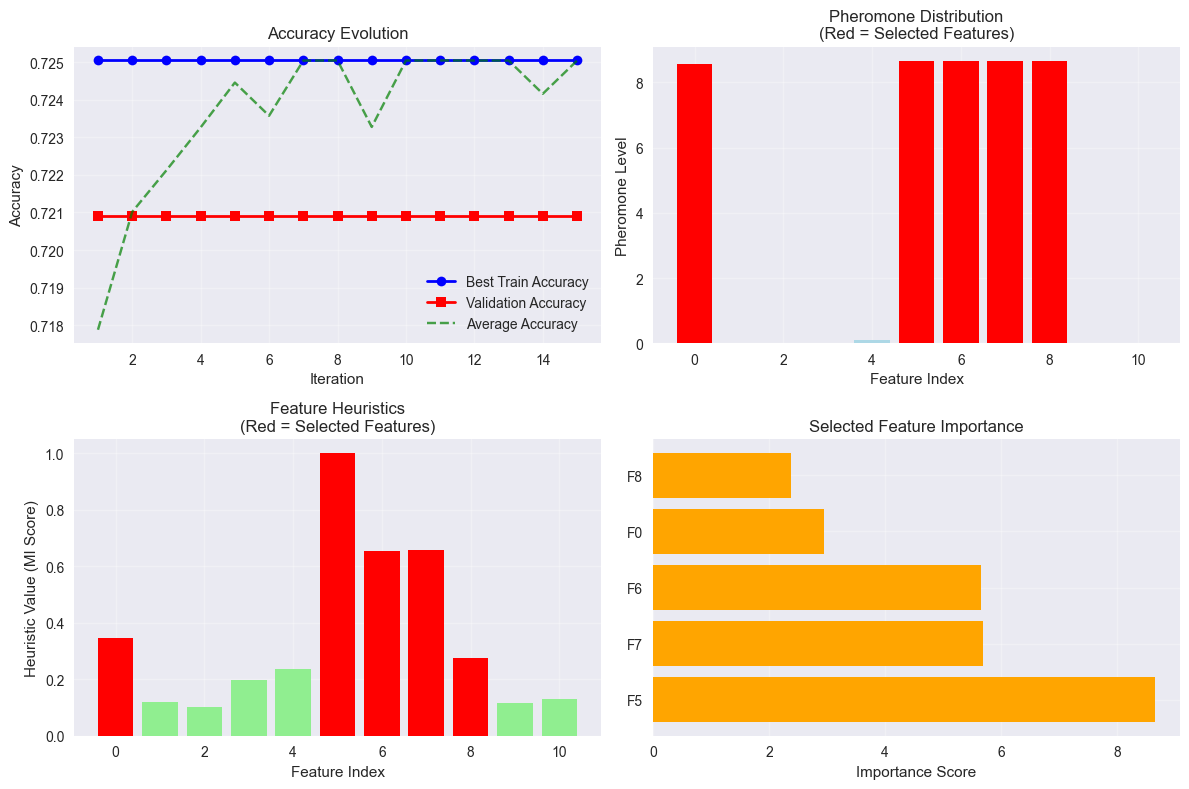

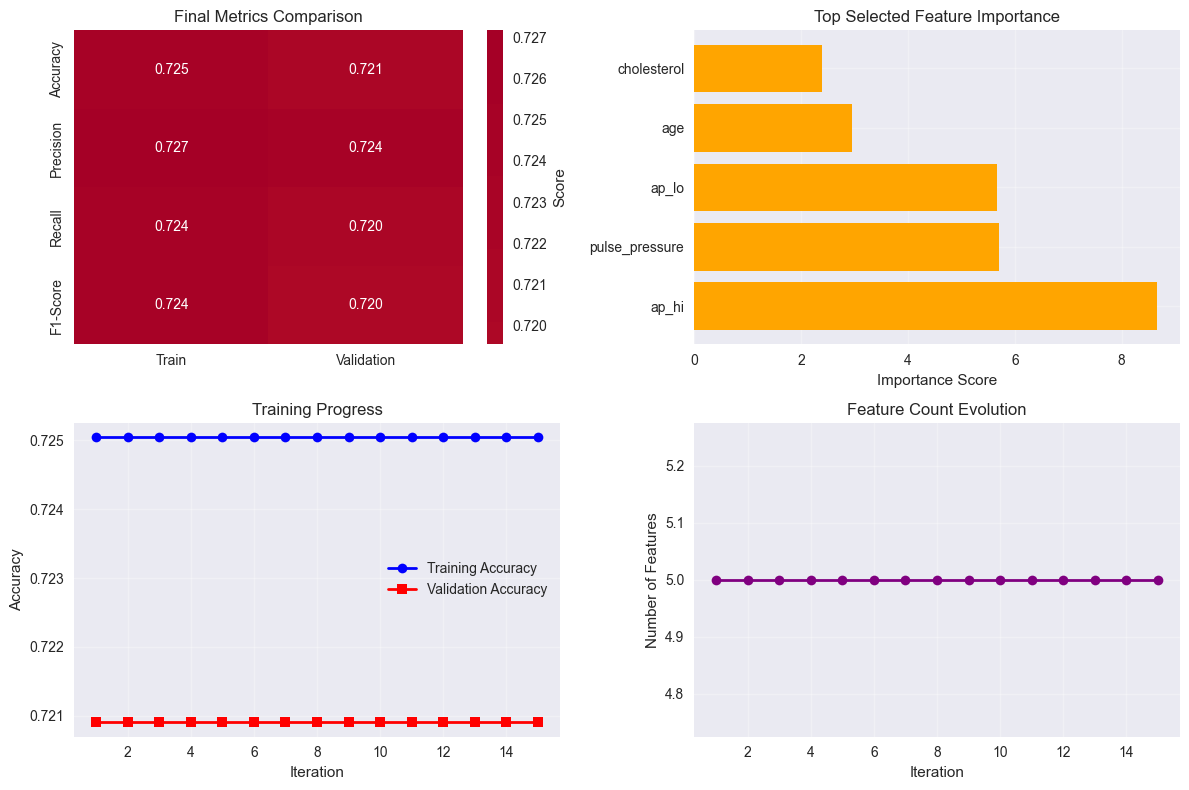

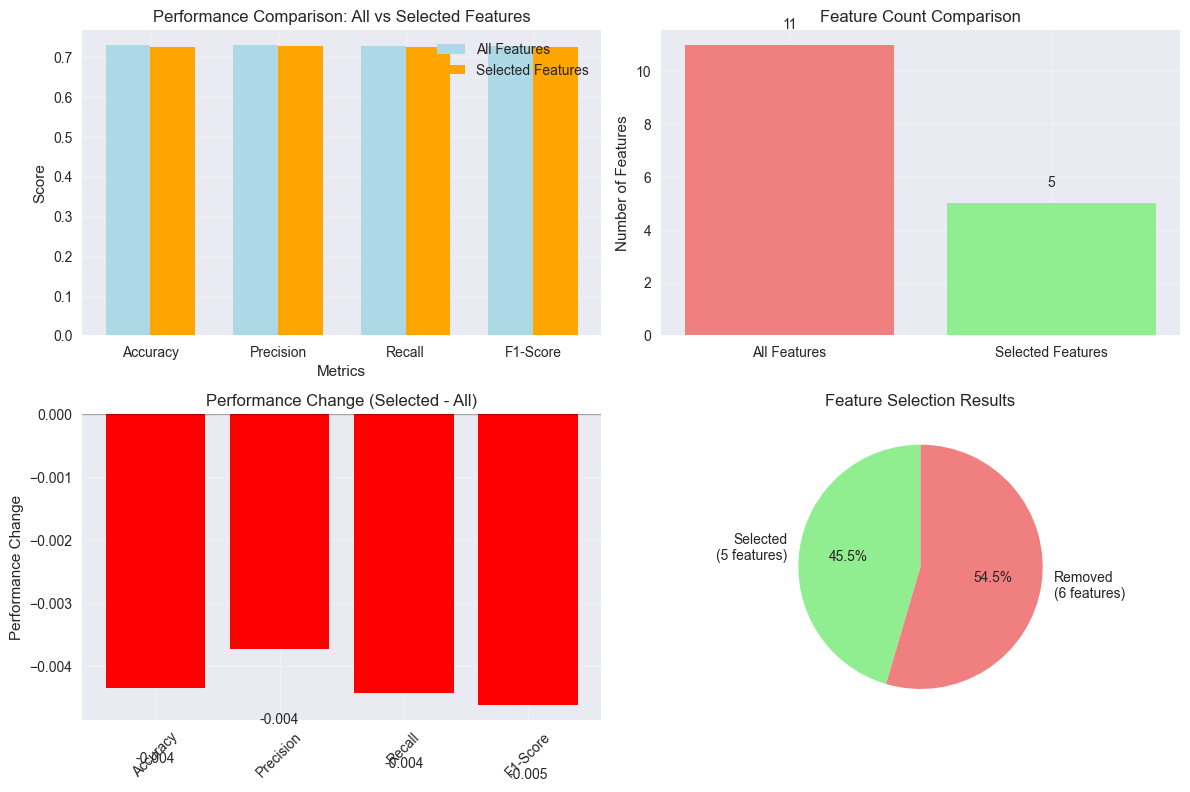


DETAILED PERFORMANCE SUMMARY
Metric          All Features    Selected        Change          % Change       
---------------------------------------------------------------------------
Accuracy        0.7303          0.7260          -0.0044         -0.60          %
Precision       0.7321          0.7284          -0.0037         -0.51          %
Recall          0.7297          0.7253          -0.0044         -0.61          %
F1              0.7294          0.7248          -0.0046         -0.63          %
---------------------------------------------------------------------------
Features        11              5               -6              -54.5          %

OVERALL ASSESSMENT:
‚ö† Accuracy decreased: -0.0044
‚úì Feature reduction achieved: 54.5%
üéØ SUCCESS: Significant feature reduction with minimal accuracy loss!


In [16]:
if __name__ == "__main__":
    aco, selected_indices, X_selected, results = run_lgbm_feature_selection(
        data_path="health_data_proccess.csv",
        target_column="group",
        n_ants=10,
        max_iter=15
    )

üöÄ RUNNING ESSENTIAL COMPARISON
üìä Showing only 5 essential charts:
   1. Performance Metrics Comparison
   2. Training Time Comparison
   3. ROC Curves / AUC Comparison
   4. Confusion Matrices
   5. Memory Usage Comparison
--------------------------------------------------
üöÄ STARTING DIRECT DATASET COMPARISON
üìÅ Raw Data: health_data_proccess.csv
üêú ACO Data: health_data_ACO_ver2.csv
üéØ Target: group
üîß Hyperparameter Tuning: Disabled
üìä Test Size: 30.0%
üöÄ STARTING COMPLETE COMPARISON
Raw Data vs ACO-Processed Data
LOADING AND PREPARING DATASETS
üìÇ Loading raw data from: health_data_proccess.csv
   ‚Ä¢ Raw data shape: (62502, 12)
   ‚Ä¢ Features: 11
   ‚Ä¢ Samples: 62502

üêú Loading ACO-processed data from: health_data_ACO_ver2.csv
   ‚Ä¢ ACO data shape: (62502, 6)
   ‚Ä¢ Features: 5
   ‚Ä¢ Samples: 62502
‚úÖ Target values are consistent between datasets

üìä DATA SUMMARY:
   ‚Ä¢ Feature reduction: 11 ‚Üí 5 (54.5% reduction)
   ‚Ä¢ Target classes: [0 1]
   ‚Ä

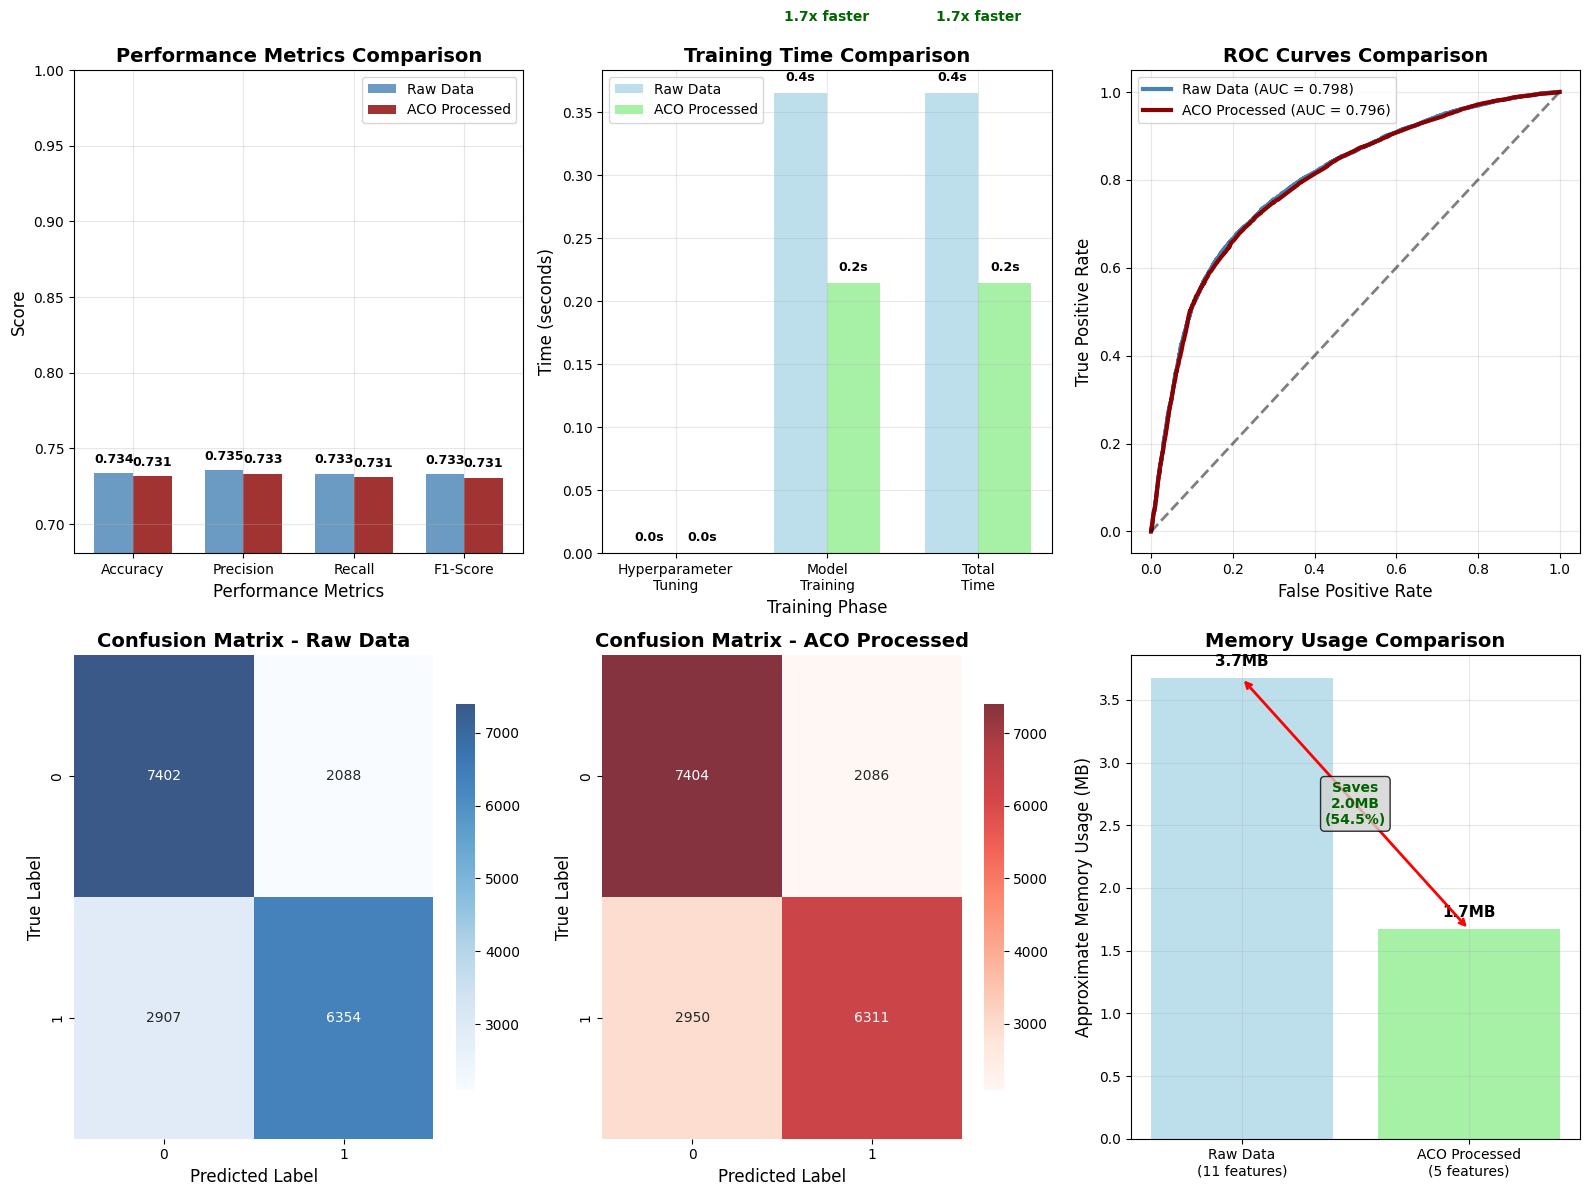


üìä ESSENTIAL VISUALIZATIONS SUMMARY
------------------------------------------------------------
‚úÖ Performance Metrics: 4 key metrics compared
‚úÖ Training Time: 0.4s vs 0.2s
‚úÖ ROC/AUC: Binary classification curves
‚úÖ Confusion Matrices: Prediction pattern comparison
‚úÖ Memory Usage: 2.0MB (54.5%) saved

                           üî• FORMATTED SUMMARY TABLE                            
‚ùå ERROR during comparison: 'DirectDataComparison' object has no attribute 'display_formatted_table'

üèÅ ESSENTIAL COMPARISON COMPLETED!


In [ ]:
# Example usage
if __name__ == "__main__":
    
    essential_results = run_direct_comparison(
        raw_data_path="health_data_proccess.csv",
        aco_data_path="health_data_ACO_ver2.csv",
        target_column="group",
        hyperparameter_tuning=False,  # Faster for testing
        test_size=0.3,
        save_results=False
    )
    
    print("\n" + "="*80)
    print("üèÅ ESSENTIAL COMPARISON COMPLETED!")
    print("="*80)

## Load Model

In [13]:
class LightGBMPredictor:
    """Class ƒë·ªÉ load v√† s·ª≠ d·ª•ng m√¥ h√¨nh LightGBM ƒë√£ l∆∞u"""
    
    def __init__(self, model_dir, model_file, info_file):
        self.model_dir = model_dir
        self.model_file = model_file
        self.info_file = info_file
        
        print(f"üîÑ ƒêang load m√¥ h√¨nh t·ª´: {model_dir}/{model_file}")
        
        # Load model info
        info_path = os.path.join(model_dir, info_file)
        with open(info_path, 'r', encoding='utf-8') as f:
            self.model_info = json.load(f)
        
        # Load native LightGBM model
        model_path = os.path.join(model_dir, model_file)
        self.model = lgb.Booster(model_file=model_path)
        
        # L·∫•y th√¥ng tin quan tr·ªçng
        self.feature_names = self.model_info["feature_names"]
        self.n_features = self.model_info["n_features"]
        self.test_auc = self.model_info["test_auc"]
        
        print(f"‚úÖ Load th√†nh c√¥ng!")
        print(f"üìä Test AUC: {self.test_auc:.4f}")
        print(f"üìù S·ªë features: {self.n_features}")
    
    def _validate_input(self, X):
        """Ki·ªÉm tra d·ªØ li·ªáu ƒë·∫ßu v√†o"""
        if isinstance(X, pd.DataFrame):
            # Ki·ªÉm tra columns
            if list(X.columns) != self.feature_names:
                missing = set(self.feature_names) - set(X.columns)
                extra = set(X.columns) - set(self.feature_names)
                error_msg = []
                if missing:
                    error_msg.append(f"Thi·∫øu features: {missing}")
                if extra:
                    error_msg.append(f"Th·ª´a features: {extra}")
                raise ValueError(". ".join(error_msg))
            
            X_array = X[self.feature_names].values  # ƒê·∫£m b·∫£o ƒë√∫ng th·ª© t·ª±
        
        elif isinstance(X, (list, np.ndarray)):
            X_array = np.array(X)
            if len(X_array.shape) == 1:
                X_array = X_array.reshape(1, -1)
            
            if X_array.shape[1] != self.n_features:
                raise ValueError(f"C·∫ßn {self.n_features} features, nh·∫≠n ƒë∆∞·ª£c {X_array.shape[1]}")
        
        else:
            raise ValueError("X ph·∫£i l√† DataFrame, list ho·∫∑c numpy array")
        
        return X_array
    
    def predict_proba(self, X):
        """
        D·ª± ƒëo√°n x√°c su·∫•t
        Returns: array v·ªõi shape (n_samples, 2) cho [prob_healthy, prob_ami]
        """
        X_array = self._validate_input(X)
        
        # Native LightGBM tr·∫£ v·ªÅ raw scores (log-odds)
        raw_scores = self.model.predict(X_array, num_iteration=self.model.best_iteration)
        
        # Convert sang probabilities b·∫±ng sigmoid
        prob_ami = 1 / (1 + np.exp(-raw_scores))  # X√°c su·∫•t AMI (class 1)
        prob_healthy = 1 - prob_ami  # X√°c su·∫•t healthy (class 0)
        
        return np.column_stack([prob_healthy, prob_ami])
    
    def predict(self, X, threshold=0.5):
        """
        D·ª± ƒëo√°n nh√£n
        Returns: array predictions (0: Healthy, 1: AMI)
        """
        probabilities = self.predict_proba(X)
        return (probabilities[:, 1] > threshold).astype(int)
    
    def predict_single_patient(self, patient_data, return_details=True):
        """
        D·ª± ƒëo√°n cho m·ªôt b·ªánh nh√¢n
        
        Args:
            patient_data: dict ho·∫∑c DataFrame v·ªõi d·ªØ li·ªáu b·ªánh nh√¢n
            return_details: c√≥ tr·∫£ v·ªÅ th√¥ng tin chi ti·∫øt kh√¥ng
        """
        # Convert sang DataFrame n·∫øu c·∫ßn
        if isinstance(patient_data, dict):
            df = pd.DataFrame([patient_data])
        else:
            df = patient_data.copy()
            if len(df) > 1:
                print("‚ö†Ô∏è  Ch·ªâ d·ª± ƒëo√°n cho b·ªánh nh√¢n ƒë·∫ßu ti√™n")
                df = df.iloc[:1]
        
        # D·ª± ƒëo√°n
        probabilities = self.predict_proba(df)
        prediction = self.predict(df)
        
        prob_healthy = probabilities[0][0]
        prob_ami = probabilities[0][1]
        pred_class = prediction[0]
        
        if return_details:
            # ƒê√°nh gi√° m·ª©c ƒë·ªô r·ªßi ro
            if prob_ami >= 0.8:
                risk_level = "R·∫•t cao üî¥üî¥"
                recommendation = "C·∫¶N KH√ÅM NGAY L·∫¨P T·ª®C!"
            elif prob_ami >= 0.6:
                risk_level = "Cao üî¥"
                recommendation = "N√™n ƒëi kh√°m tim m·∫°ch trong tu·∫ßn n√†y"
            elif prob_ami >= 0.4:
                risk_level = "Trung b√¨nh üü°"
                recommendation = "Theo d√µi v√† kh√°m ƒë·ªãnh k·ª≥"
            else:
                risk_level = "Th·∫•p üü¢"
                recommendation = "Duy tr√¨ l·ªëi s·ªëng l√†nh m·∫°nh"
            
            result = {
                "prediction": int(pred_class),
                "prediction_label": "AMI (ƒêau tim c·∫•p)" if pred_class == 1 else "Healthy (Kh·ªèe m·∫°nh)",
                "probability_healthy": round(float(prob_healthy), 4),
                "probability_ami": round(float(prob_ami), 4),
                "probability_ami_percent": f"{prob_ami:.1%}",
                "risk_level": risk_level,
                "recommendation": recommendation
            }
            return result
        else:
            return int(pred_class), float(prob_ami)
    
    def batch_predict(self, data_file, output_file=None):
        """
        D·ª± ƒëo√°n cho nhi·ªÅu b·ªánh nh√¢n t·ª´ file CSV
        
        Args:
            data_file: ƒë∆∞·ªùng d·∫´n file CSV ch·ª©a d·ªØ li·ªáu
            output_file: ƒë∆∞·ªùng d·∫´n file output (t√πy ch·ªçn)
        """
        # ƒê·ªçc d·ªØ li·ªáu
        df = pd.read_csv(data_file)
        print(f"üìä ƒê·ªçc ƒë∆∞·ª£c {len(df)} b·ªánh nh√¢n t·ª´ {data_file}")
        
        # D·ª± ƒëo√°n
        probabilities = self.predict_proba(df)
        predictions = self.predict(df)
        
        # T·∫°o k·∫øt qu·∫£
        results = df.copy()
        results['prediction'] = predictions
        results['prediction_label'] = ['AMI' if p == 1 else 'Healthy' for p in predictions]
        results['probability_healthy'] = probabilities[:, 0]
        results['probability_ami'] = probabilities[:, 1]
        results['risk_level'] = ['Cao üî¥' if p > 0.6 else 'Trung b√¨nh üü°' if p > 0.4 else 'Th·∫•p üü¢' 
                                for p in probabilities[:, 1]]
        
        # L∆∞u k·∫øt qu·∫£
        if output_file:
            results.to_csv(output_file, index=False, encoding='utf-8')
            print(f"‚úÖ ƒê√£ l∆∞u k·∫øt qu·∫£ v√†o: {output_file}")
        
        return results
    
    def get_feature_importance(self):
        """L·∫•y feature importance n·∫øu c√≥ file"""
        importance_file = self.model_file.replace('_native.txt', '_feature_importance.csv')
        importance_path = os.path.join(self.model_dir, importance_file)
        
        if os.path.exists(importance_path):
            return pd.read_csv(importance_path)
        else:
            print("‚ö†Ô∏è  Kh√¥ng t√¨m th·∫•y file feature importance")
            return None
    
    def print_model_summary(self):
        """In th√¥ng tin t√≥m t·∫Øt v·ªÅ m√¥ h√¨nh"""
        print(f"\n{'='*50}")
        print("üìã TH√îNG TIN M√î H√åNH")
        print(f"{'='*50}")
        print(f"üè∑Ô∏è  T√™n: {self.model_info['model_name']}")
        print(f"üïê T·∫°o l√∫c: {self.model_info['created_at']}")
        print(f"üß† Thu·∫≠t to√°n: {self.model_info['algorithm']}")
        print(f"üìä Test AUC: {self.test_auc:.4f}")
        print(f"üìä Test Accuracy: {self.model_info['test_accuracy']:.4f}")
        print(f"üìù S·ªë features: {self.n_features}")
        print(f"üéØ Classes: {', '.join(self.model_info['target_classes'].values())}")

## ACO to OPTIMIZE PARAMETER LGBM

In [14]:
# ƒê·ªçc file d·ªØ li·ªáu sau khi remove feature
df_1 = pd.read_csv('health_data_ACO_ver2.csv')

X_ACO_optimized = df_1.drop('group', axis=1)
y_ACO_optimized = df_1['group']  # Bi·∫øn m·ª•c ti√™u (0: Kh·ªèe m·∫°nh, 1: AMI)

X_train, X_test, y_train, y_test = train_test_split(
    X_ACO_optimized, y_ACO_optimized, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_ACO_optimized
)

param_space = {
    "num_leaves": [15, 31, 63, 127, 255],           # Xung quanh 31
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2], # Xung quanh 0.1
    "min_child_weight": [0.001, 0.01, 0.1, 0.5],   # Xung quanh 0.001
    "min_child_samples": [10, 20, 40, 60, 80],      # Xung quanh 20
    "subsample": [0.6, 0.8, 1.0],                   # Xung quanh 1.0
    "colsample_bytree": [0.6, 0.8, 1.0],           # Xung quanh 1.0
    "subsample_freq": [0, 1, 5],                    # Xung quanh 0
    "boosting_type": ['gbdt'],                       # C·ªë ƒë·ªãnh gbdt
    "subsample_for_bin": [200000],                  # C·ªë ƒë·ªãnh 200000
    "importance_type": ['split']                     # C·ªë ƒë·ªãnh split

}

# 4. ‚úÖ ƒê√öNG: Ch·ªâ s·ª≠ d·ª•ng training set cho hyperparameter optimization
print("B·∫Øt ƒë·∫ßu t·ªëi ∆∞u hyperparameters tr√™n training set...")
aco_hyper = ACOHyperparameterOptimizer(param_space, n_ants=10, max_iter=10, metric="auc")
best_params, best_score = aco_hyper.fit(X_train, y_train)  # ‚úÖ Ch·ªâ d√πng train set

print("Best params:", best_params)
print("Best AUC on training:", best_score)

# 5. ‚úÖ ƒê√öNG: Train m√¥ h√¨nh cu·ªëi ch·ªâ tr√™n training set
print("Training m√¥ h√¨nh cu·ªëi v·ªõi hyperparameters t·ªëi ∆∞u...")
final_model = lgb.LGBMClassifier(**best_params, n_estimators=300, random_state=42)
final_model.fit(X_train, y_train)  # ‚úÖ Ch·ªâ d√πng train set

# 6. ‚úÖ ƒê√öNG: ƒê√°nh gi√° m√¥ h√¨nh tr√™n test set (ch∆∞a t·ª´ng ƒë∆∞·ª£c nh√¨n th·∫•y)
print("ƒê√°nh gi√° m√¥ h√¨nh tr√™n test set...")
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# ƒê·ªô ch√≠nh x√°c
accuracy = accuracy_score(y_test, y_pred)
print(f"ƒê·ªô ch√≠nh x√°c tr√™n test set: {accuracy:.4f}")

# AUC tr√™n test set
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test, y_prob)
print(f"AUC tr√™n test set: {test_auc:.4f}")

# B√°o c√°o ph√¢n lo·∫°i
print("\nB√°o c√°o ph√¢n lo·∫°i:")
print(classification_report(y_test, y_pred))

# Ma tr·∫≠n nh·∫ßm l·∫´n
cm = confusion_matrix(y_test, y_pred)
print("\nMa tr·∫≠n nh·∫ßm l·∫´n:")
print(cm)

B·∫Øt ƒë·∫ßu t·ªëi ∆∞u hyperparameters tr√™n training set...
[LightGBM] [Info] Number of positive: 17285, number of negative: 17715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493857 -> initscore=-0.024573
[LightGBM] [Info] Start training from score -0.024573
[LightGBM] [Info] Number of positive: 17285, number of negative: 17715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train 

In [15]:
# B√°o c√°o ph√¢n lo·∫°i
print("\nB√°o c√°o ph√¢n lo·∫°i:")
print(classification_report(y_test, y_pred))

# Ma tr·∫≠n nh·∫ßm l·∫´n
cm = confusion_matrix(y_test, y_pred)
print("\nMa tr·∫≠n nh·∫ßm l·∫´n:")
print(cm)


B√°o c√°o ph√¢n lo·∫°i:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      9490
           1       0.75      0.69      0.72      9261

    accuracy                           0.73     18751
   macro avg       0.73      0.73      0.73     18751
weighted avg       0.73      0.73      0.73     18751


Ma tr·∫≠n nh·∫ßm l·∫´n:
[[7325 2165]
 [2863 6398]]


In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

# =============================================================================
# üöÄ L∆ØU M√î H√åNH B·∫∞NG NATIVE LIGHTGBM
# =============================================================================

# T·∫°o th∆∞ m·ª•c l∆∞u tr·ªØ
save_dir = "native_model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"lightgbm_aco_{timestamp}"

print(f"üîÑ ƒêang l∆∞u m√¥ h√¨nh: {model_name}")

# =============================================================================
# 1. ‚úÖ L∆ØU M√î H√åNH NATIVE LIGHTGBM (CH√çNH)
# =============================================================================

# L∆∞u m√¥ h√¨nh native
model_path = os.path.join(save_dir, f"{model_name}_native.txt")
final_model.booster_.save_model(model_path)
print(f"‚úÖ ƒê√£ l∆∞u native model: {model_path}")

# =============================================================================
# 2. ‚úÖ L∆ØU TH√îNG TIN M√î H√åNH
# =============================================================================

# T√≠nh metrics tr√™n test set
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_prob)
test_accuracy = accuracy_score(y_test, y_pred)

# Th√¥ng tin m√¥ h√¨nh
model_info = {
    "model_name": model_name,
    "created_at": timestamp,
    "algorithm": "LightGBM + ACO optimization",
    "model_file": f"{model_name}_native.txt",
    
    # Hyperparameters
    "best_params": best_params,
    "n_estimators": final_model.n_estimators,
    
    # Data info
    "n_features": X_train.shape[1],
    "feature_names": list(X_train.columns),
    "n_train_samples": X_train.shape[0],
    "n_test_samples": X_test.shape[0],
    
    # Performance
    "training_auc": float(best_score),
    "test_auc": float(test_auc),
    "test_accuracy": float(test_accuracy),
    
    # Target info
    "target_classes": {
        "0": "Healthy (Kh·ªèe m·∫°nh)", 
        "1": "AMI (ƒêau tim c·∫•p)"
    }
}

# L∆∞u th√¥ng tin
info_path = os.path.join(save_dir, f"{model_name}_info.json")
with open(info_path, 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=2, ensure_ascii=False)
print(f"‚úÖ ƒê√£ l∆∞u model info: {info_path}")

import json
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

# =============================================================================
# üöÄ L∆ØU M√î H√åNH B·∫∞NG NATIVE LIGHTGBM
# =============================================================================

# T·∫°o th∆∞ m·ª•c l∆∞u tr·ªØ
save_dir = "native_model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"model_baseline"

print(f"üîÑ ƒêang l∆∞u m√¥ h√¨nh: {model_name}")

# =============================================================================
# 1. ‚úÖ L∆ØU M√î H√åNH NATIVE LIGHTGBM (CH√çNH)
# =============================================================================

# L∆∞u m√¥ h√¨nh native
model_path = os.path.join(save_dir, f"{model_name}_native.txt")
final_model.booster_.save_model(model_path)
print(f"‚úÖ ƒê√£ l∆∞u native model: {model_path}")

# =============================================================================
# 2. ‚úÖ L∆ØU TH√îNG TIN M√î H√åNH
# =============================================================================

# T√≠nh metrics tr√™n test set
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_prob)
test_accuracy = accuracy_score(y_test, y_pred)

# Th√¥ng tin m√¥ h√¨nh
model_info = {
    "model_name": model_name,
    "created_at": timestamp,
    "algorithm": "LightGBM + ACO optimization",
    "model_file": f"{model_name}_native.txt",
    
    # Hyperparameters
    "best_params": best_params,
    "n_estimators": final_model.n_estimators,
    
    # Data info
    "n_features": X_train.shape[1],
    "feature_names": list(X_train.columns),
    "n_train_samples": X_train.shape[0],
    "n_test_samples": X_test.shape[0],
    
    # Performance
    "training_auc": float(best_score),
    "test_auc": float(test_auc),
    "test_accuracy": float(test_accuracy),
    
    # Target info
    "target_classes": {
        "0": "Healthy (Kh·ªèe m·∫°nh)", 
        "1": "AMI (ƒêau tim c·∫•p)"
    }
}

# L∆∞u th√¥ng tin
info_path = os.path.join(save_dir, f"{model_name}_info.json")
with open(info_path, 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=2, ensure_ascii=False)
print(f"‚úÖ ƒê√£ l∆∞u model info: {info_path}")


# =============================================================================
# 4. ‚úÖ L∆ØU K·∫æT QU·∫¢ ƒê√ÅNH GI√Å
# =============================================================================

# Confusion matrix v√† classification report
cm = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

evaluation = {
    "confusion_matrix": cm.tolist(),
    "classification_report": class_report,
    "test_predictions": {
        "y_true": y_test.tolist(),
        "y_pred": y_pred.tolist(), 
        "y_prob": y_prob.tolist()
    }
}

eval_path = os.path.join(save_dir, f"{model_name}_evaluation.json")
with open(eval_path, 'w', encoding='utf-8') as f:
    json.dump(evaluation, f, indent=2, ensure_ascii=False)
print(f"‚úÖ ƒê√£ l∆∞u evaluation: {eval_path}")


üîÑ ƒêang l∆∞u m√¥ h√¨nh: lightgbm_aco_20250924_125901
‚úÖ ƒê√£ l∆∞u native model: native_model\lightgbm_aco_20250924_125901_native.txt
‚úÖ ƒê√£ l∆∞u model info: native_model\lightgbm_aco_20250924_125901_info.json
üîÑ ƒêang l∆∞u m√¥ h√¨nh: lightgbm_aco_20250924_125901
‚úÖ ƒê√£ l∆∞u native model: native_model\lightgbm_aco_20250924_125901_native.txt
‚úÖ ƒê√£ l∆∞u model info: native_model\lightgbm_aco_20250924_125901_info.json
‚úÖ ƒê√£ l∆∞u evaluation: native_model\lightgbm_aco_20250924_125901_evaluation.json


In [25]:
# L∆∞u th√¥ng tin c·∫ßn thi·∫øt ƒë·ªÉ load model
load_info = {
    "model_file": f"{model_name}_native.txt",
    "model_dir": save_dir,
    "feature_names": list(X_train.columns),
    "n_features": len(X_train.columns),
    "test_auc": float(test_auc),
    "test_accuracy": float(test_accuracy)
}

# In ra th√¥ng tin ƒë·ªÉ copy
print(f"\nüí° TH√îNG TIN ƒê·ªÇ LOAD MODEL:")
print(f"MODEL_FILE = '{model_name}_native.txt'")
print(f"MODEL_DIR = '{save_dir}'")
print(f"N_FEATURES = {len(X_train.columns)}")
print(f"FEATURE_NAMES = {list(X_train.columns)}")

print(f"\n‚úÖ Code c·ªßa b·∫°n ƒë√£ ƒë·ªß ƒë·ªÉ l∆∞u m√¥ h√¨nh c∆° b·∫£n!")


üí° TH√îNG TIN ƒê·ªÇ LOAD MODEL:
MODEL_FILE = 'lightgbm_aco_20250924_125901_native.txt'
MODEL_DIR = 'native_model'
N_FEATURES = 5
FEATURE_NAMES = ['age', 'ap_hi', 'ap_lo', 'pulse_pressure', 'cholesterol']

‚úÖ Code c·ªßa b·∫°n ƒë√£ ƒë·ªß ƒë·ªÉ l∆∞u m√¥ h√¨nh c∆° b·∫£n!


In [16]:
X_ori = df_1.drop('group', axis=1)
y_ori = df_1['group']  # Bi·∫øn m·ª•c ti√™u (0: Kh·ªèe m·∫°nh, 1: AMI)

# 2. Chia d·ªØ li·ªáu th√†nh t·∫≠p hu·∫•n luy·ªán v√† t·∫≠p ki·ªÉm tra
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_ori, y_ori, test_size=0.3, random_state=42, stratify=y_ori)

# 3. ƒê·ªãnh nghƒ©a c√°c tham s·ªë cho m√¥ h√¨nh LGBM
params = {
    'boosting_type': 'gbdt',
    'n_estimators': 300,
    'num_leaves': 31,  
    'learning_rate': 0.1,  
    'subsample_for_bin': 200000,
    'min_child_weight': 0.001,  
    'min_child_samples': 20,  
    'subsample': 1,  
    'subsample_freq': 0,  
    'colsample_bytree': 1.0,  
    'importance_type': 'split',
    'random_state': 42
}

# 4. Hu·∫•n luy·ªán m√¥ h√¨nh LGBM
model = lgbm.LGBMClassifier(**params)
model.fit(X_train_final, y_train_final)

# 5. ƒê√°nh gi√° m√¥ h√¨nh
y_pred = model.predict(X_test_final)
y_prob = model.predict_proba(X_test_final)[:, 1]

# ƒê·ªô ch√≠nh x√°c
accuracy = accuracy_score(y_test_final, y_pred)
print(f"ƒê·ªô ch√≠nh x√°c: {accuracy:.4f}")

# B√°o c√°o ph√¢n lo·∫°i
print("\nB√°o c√°o ph√¢n lo·∫°i:")
print(classification_report(y_test_final, y_pred))

# Ma tr·∫≠n nh·∫ßm l·∫´n
cm = confusion_matrix(y_test_final, y_pred)
print("\nMa tr·∫≠n nh·∫ßm l·∫´n:")
print(cm)

[LightGBM] [Info] Number of positive: 21607, number of negative: 22144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 43751, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493863 -> initscore=-0.024549
[LightGBM] [Info] Start training from score -0.024549
ƒê·ªô ch√≠nh x√°c: 0.7315

B√°o c√°o ph√¢n lo·∫°i:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      9490
           1       0.75      0.68      0.71      9261

    accuracy                           0.73     18751
   macro avg       0.73      0.73      0.73     18751
weighted avg       0.73      0.73      0.73     18751


Ma tr·∫≠n nh·∫ßm l·∫´n:
[[7410 2080]
 [2955 6306]]


SO S√ÅNH HI·ªÜU SU·∫§T: FINAL_MODEL (ACO) VS MODEL (DEFAULT)

üìä ƒêANG TH·ª∞C HI·ªÜN D·ª∞ ƒêO√ÅN TR√äN TEST SET...
üîµ D·ª± ƒëo√°n v·ªõi ACO optimized model...
üî¥ D·ª± ƒëo√°n v·ªõi Default model...
‚úÖ Ho√†n th√†nh d·ª± ƒëo√°n!

üìà T√çNH TO√ÅN V√Ä SO S√ÅNH METRICS

üìã B·∫¢NG SO S√ÅNH CHI TI·∫æT:
-------------------------------------------------------------------------------------
Metric       | ACO Optimized | Default       | Improvement  | Improvement %
-------------------------------------------------------------------------------------
Accuracy     | 0.7320        | 0.7315        |      +0.0005 |       +0.07% üìà
Precision    | 0.7608        | 0.7520        |      +0.0089 |       +1.18% üìà
Recall       | 0.6671        | 0.6809        |      -0.0138 |       -2.03% üìâ
F1-Score     | 0.7109        | 0.7147        |      -0.0038 |       -0.53% üìâ
AUC          | 0.7973        | 0.7946        |      +0.0027 |       +0.34% üìà

üîç PH√ÇN T√çCH CHI TI·∫æT

üèÜ T·ªïng quan

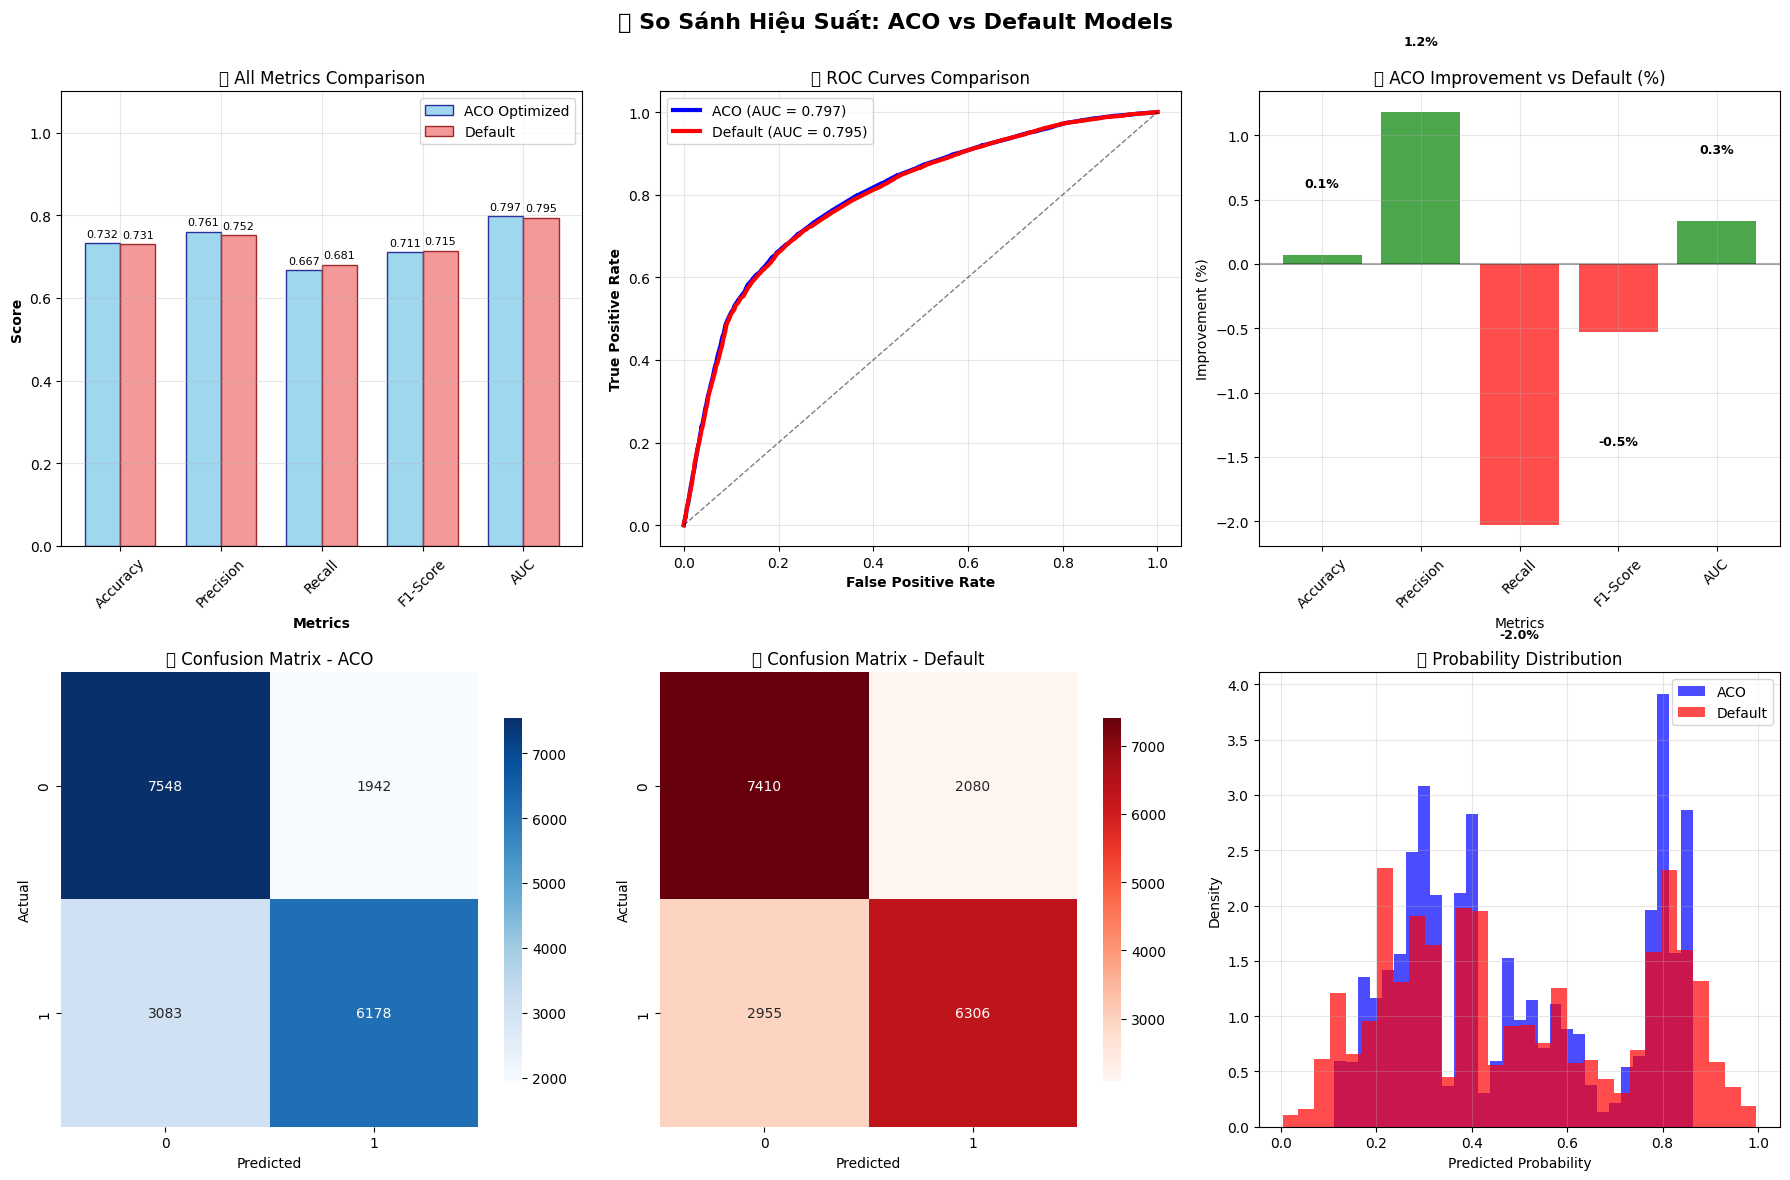


üèÜ K·∫æT LU·∫¨N CU·ªêI C√ôNG

ü•á M√î H√åNH TH·∫ÆNG CU·ªòC: ACO Optimized

‚úÖ L√Ω do ACO th·∫Øng:
   üìà Accuracy: +0.0005 (+0.07%)
   üìà Precision: +0.0089 (+1.18%)
   üìà AUC: +0.0027 (+0.34%)

üìè M·ª©c ƒë·ªô c·∫£i thi·ªán AUC: nh·ªè (0.0027)

üí° KHUY·∫æN NGH·ªä:
   ‚ö†Ô∏è C√≥ th·ªÉ s·ª≠ d·ª•ng c·∫£ 2 m√¥ h√¨nh
   üìù C·∫£i thi·ªán nh·ªè, default c≈©ng ƒë·ªß t·ªët

üìä T√≥m t·∫Øt s·ªë li·ªáu:
   üéØ Test set size: 18751 samples
   ‚öñÔ∏è Class balance: [9490 9261]
   üîµ ACO errors: 5025/18751 (26.8%)
   üî¥ Default errors: 5035/18751 (26.9%)

üéâ Ho√†n th√†nh so s√°nh!


In [ ]:
print("="*80)
print("SO S√ÅNH HI·ªÜU SU·∫§T: FINAL_MODEL (ACO) VS MODEL (DEFAULT)")
print("="*80)

# 1. D·ª∞ ƒêO√ÅN TR√äN TEST SET
print("\nüìä ƒêANG TH·ª∞C HI·ªÜN D·ª∞ ƒêO√ÅN TR√äN TEST SET...")

# D·ª± ƒëo√°n cho m√¥ h√¨nh ACO (final_model)
print("üîµ D·ª± ƒëo√°n v·ªõi ACO optimized model...")
y_pred_aco = final_model.predict(X_test)
y_prob_aco = final_model.predict_proba(X_test)[:, 1]

# D·ª± ƒëo√°n cho m√¥ h√¨nh Default (model)
print("üî¥ D·ª± ƒëo√°n v·ªõi Default model...")
y_pred_default = model.predict(X_test)
y_prob_default = model.predict_proba(X_test)[:, 1]

print("‚úÖ Ho√†n th√†nh d·ª± ƒëo√°n!")

# 2. T√çNH TO√ÅN METRICS CHO C·∫¢ 2 M√î H√åNH
print(f"\n{'='*60}")
print("üìà T√çNH TO√ÅN V√Ä SO S√ÅNH METRICS")
print("="*60)

def calculate_all_metrics(y_true, y_pred, y_prob, model_name):
    """T√≠nh to√°n t·∫•t c·∫£ metrics cho m·ªôt m√¥ h√¨nh"""
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)
    }
    return metrics

# T√≠nh metrics cho c·∫£ 2 m√¥ h√¨nh
metrics_aco = calculate_all_metrics(y_test, y_pred_aco, y_prob_aco, "ACO Optimized")
metrics_default = calculate_all_metrics(y_test, y_pred_default, y_prob_default, "Default")

# T·∫°o b·∫£ng so s√°nh chi ti·∫øt
comparison_data = []
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

print("\nüìã B·∫¢NG SO S√ÅNH CHI TI·∫æT:")
print("-" * 85)
print(f"{'Metric':<12} | {'ACO Optimized':<13} | {'Default':<13} | {'Improvement':<12} | {'Improvement %':<12}")
print("-" * 85)

for metric in metric_names:
    aco_val = metrics_aco[metric]
    default_val = metrics_default[metric]
    improvement = aco_val - default_val
    improvement_pct = (improvement / default_val) * 100 if default_val != 0 else 0
    
    comparison_data.append({
        'Metric': metric,
        'ACO Optimized': aco_val,
        'Default': default_val,
        'Improvement': improvement,
        'Improvement (%)': improvement_pct
    })
    
    # In t·ª´ng d√≤ng v·ªõi formatting ƒë·∫πp
    symbol = "üìà" if improvement > 0 else "üìâ" if improvement < 0 else "‚û°Ô∏è"
    print(f"{metric:<12} | {aco_val:<13.4f} | {default_val:<13.4f} | "
          f"{improvement:+12.4f} | {improvement_pct:+11.2f}% {symbol}")

comparison_df = pd.DataFrame(comparison_data)

# 3. PH√ÇN T√çCH CHI TI·∫æT
print(f"\n{'='*60}")
print("üîç PH√ÇN T√çCH CHI TI·∫æT")
print("="*60)

# So s√°nh t·ªïng th·ªÉ
better_count = sum(1 for improvement in comparison_df['Improvement'] if improvement > 0)
total_metrics = len(comparison_df)

print(f"\nüèÜ T·ªïng quan:")
print(f"   - ACO th·∫Øng trong {better_count}/{total_metrics} metrics")
print(f"   - Default th·∫Øng trong {total_metrics - better_count}/{total_metrics} metrics")

# Metric quan tr·ªçng nh·∫•t (AUC)
auc_improvement = metrics_aco['AUC'] - metrics_default['AUC']
print(f"\nüéØ Metric quan tr·ªçng nh·∫•t (AUC):")
print(f"   - ACO AUC: {metrics_aco['AUC']:.4f}")
print(f"   - Default AUC: {metrics_default['AUC']:.4f}")
print(f"   - C·∫£i thi·ªán: {auc_improvement:+.4f} ({(auc_improvement/metrics_default['AUC'])*100:+.2f}%)")

# 4. CLASSIFICATION REPORTS CHI TI·∫æT
print(f"\n{'='*60}")
print("üìã CLASSIFICATION REPORTS CHI TI·∫æT")
print("="*60)

print("\nüîµ ACO OPTIMIZED MODEL:")
print("-" * 50)
print(classification_report(y_test, y_pred_aco))

print("\nüî¥ DEFAULT MODEL:")
print("-" * 50)
print(classification_report(y_test, y_pred_default))

# 5. CONFUSION MATRICES
print(f"\n{'='*60}")
print("üî¢ CONFUSION MATRICES")
print("="*60)

cm_aco = confusion_matrix(y_test, y_pred_aco)
cm_default = confusion_matrix(y_test, y_pred_default)

print(f"\nüîµ ACO Confusion Matrix:")
print(f"     Predicted")
print(f"       0    1")
print(f"Act 0 {cm_aco[0,0]:3} {cm_aco[0,1]:4}")
print(f"Act 1 {cm_aco[1,0]:3} {cm_aco[1,1]:4}")

print(f"\nüî¥ Default Confusion Matrix:")
print(f"     Predicted")
print(f"       0    1")
print(f"Act 0 {cm_default[0,0]:3} {cm_default[0,1]:4}")
print(f"Act 1 {cm_default[1,0]:3} {cm_default[1,1]:4}")

# So s√°nh errors
aco_errors = cm_aco[0,1] + cm_aco[1,0]  # False positives + False negatives
default_errors = cm_default[0,1] + cm_default[1,0]
error_reduction = default_errors - aco_errors

print(f"\nüìä Error Analysis:")
print(f"   - ACO total errors: {aco_errors}")
print(f"   - Default total errors: {default_errors}")
print(f"   - Error reduction: {error_reduction} ({'better' if error_reduction > 0 else 'worse'})")

# 6. VISUALIZATIONS
print(f"\n{'='*60}")
print("üìà T·∫†O BI·ªÇU ƒê·ªí SO S√ÅNH")
print("="*60)

# Thi·∫øt l·∫≠p style
plt.style.use('default')
sns.set_palette("husl")

# T·∫°o figure v·ªõi subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('üèÜ So S√°nh Hi·ªáu Su·∫•t: ACO vs Default Models', fontsize=16, fontweight='bold')

# 1. Metrics Comparison Bar Chart
ax1 = axes[0, 0]
x_pos = np.arange(len(metric_names))
width = 0.35

aco_values = [metrics_aco[metric] for metric in metric_names]
default_values = [metrics_default[metric] for metric in metric_names]

bars1 = ax1.bar(x_pos - width/2, aco_values, width, label='ACO Optimized', 
               alpha=0.8, color='skyblue', edgecolor='navy')
bars2 = ax1.bar(x_pos + width/2, default_values, width, label='Default', 
               alpha=0.8, color='lightcoral', edgecolor='darkred')

ax1.set_xlabel('Metrics', fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('üìä All Metrics Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metric_names, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. ROC Curves Comparison
ax2 = axes[0, 1]
fpr_aco, tpr_aco, _ = roc_curve(y_test, y_prob_aco)
fpr_default, tpr_default, _ = roc_curve(y_test, y_prob_default)

ax2.plot(fpr_aco, tpr_aco, label=f'ACO (AUC = {metrics_aco["AUC"]:.3f})', 
         linewidth=3, color='blue')
ax2.plot(fpr_default, tpr_default, label=f'Default (AUC = {metrics_default["AUC"]:.3f})', 
         linewidth=3, color='red')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.set_title('üìà ROC Curves Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Improvement Percentage
ax3 = axes[0, 2]
improvements = [row['Improvement (%)'] for _, row in comparison_df.iterrows()]
colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in improvements]
bars = ax3.bar(range(len(improvements)), improvements, color=colors, alpha=0.7)
ax3.set_xlabel('Metrics')
ax3.set_ylabel('Improvement (%)')
ax3.set_title('üìà ACO Improvement vs Default (%)')
ax3.set_xticks(range(len(improvements)))
ax3.set_xticklabels(metric_names, rotation=45)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, improvements)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -0.8),
            f'{val:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
            fontsize=9, fontweight='bold')

# 4. Confusion Matrix - ACO
ax4 = axes[1, 0]
sns.heatmap(cm_aco, annot=True, fmt='d', cmap='Blues', ax=ax4, 
            cbar_kws={'shrink': 0.8})
ax4.set_title('üîµ Confusion Matrix - ACO')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

# 5. Confusion Matrix - Default
ax5 = axes[1, 1]
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Reds', ax=ax5,
            cbar_kws={'shrink': 0.8})
ax5.set_title('üî¥ Confusion Matrix - Default')
ax5.set_xlabel('Predicted')
ax5.set_ylabel('Actual')

# 6. Probability Distribution Comparison
ax6 = axes[1, 2]
ax6.hist(y_prob_aco, bins=30, alpha=0.7, label='ACO', color='blue', density=True)
ax6.hist(y_prob_default, bins=30, alpha=0.7, label='Default', color='red', density=True)
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Density')
ax6.set_title('üìä Probability Distribution')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. K·∫æT LU·∫¨N CU·ªêI C√ôNG
print(f"\n{'='*60}")
print("üèÜ K·∫æT LU·∫¨N CU·ªêI C√ôNG")
print("="*60)

# X√°c ƒë·ªãnh winner
better_model = "ACO Optimized" if metrics_aco['AUC'] > metrics_default['AUC'] else "Default"
winner_symbol = "ü•á" if better_model == "ACO Optimized" else "ü•à"

print(f"\n{winner_symbol} M√î H√åNH TH·∫ÆNG CU·ªòC: {better_model}")

if better_model == "ACO Optimized":
    print(f"\n‚úÖ L√Ω do ACO th·∫Øng:")
    for metric in metric_names:
        improvement = comparison_df[comparison_df['Metric']==metric]['Improvement'].iloc[0]
        if improvement > 0:
            improvement_pct = comparison_df[comparison_df['Metric']==metric]['Improvement (%)'].iloc[0]
            print(f"   üìà {metric}: +{improvement:.4f} (+{improvement_pct:.2f}%)")
else:
    print(f"\nüìä Default model v·∫´n t·ªët h∆°n:")
    for metric in metric_names:
        improvement = comparison_df[comparison_df['Metric']==metric]['Improvement'].iloc[0]
        if improvement < 0:
            improvement_pct = comparison_df[comparison_df['Metric']==metric]['Improvement (%)'].iloc[0]
            print(f"   üìâ {metric}: {improvement:.4f} ({improvement_pct:.2f}%)")

# Significance of improvement
abs_auc_improvement = abs(auc_improvement)
if abs_auc_improvement > 0.02:
    significance = "ƒë√°ng k·ªÉ"
elif abs_auc_improvement > 0.01:
    significance = "v·ª´a ph·∫£i"
else:
    significance = "nh·ªè"

print(f"\nüìè M·ª©c ƒë·ªô c·∫£i thi·ªán AUC: {significance} ({abs_auc_improvement:.4f})")

# Recommendation
print(f"\nüí° KHUY·∫æN NGH·ªä:")
if better_model == "ACO Optimized" and abs_auc_improvement > 0.01:
    print("   ‚úÖ N√™n s·ª≠ d·ª•ng m√¥ h√¨nh ACO Optimized")
    print("   üìù ACO ƒë√£ t√¨m ƒë∆∞·ª£c parameters t·ªët h∆°n default")
elif better_model == "ACO Optimized" and abs_auc_improvement <= 0.01:
    print("   ‚ö†Ô∏è C√≥ th·ªÉ s·ª≠ d·ª•ng c·∫£ 2 m√¥ h√¨nh")
    print("   üìù C·∫£i thi·ªán nh·ªè, default c≈©ng ƒë·ªß t·ªët")
else:
    print("   üìã Default parameters ƒë√£ kh√° t·ªëi ∆∞u")
    print("   üìù C·∫ßn xem x√©t ƒëi·ªÅu ch·ªânh ACO algorithm")

# Summary stats
print(f"\nüìä T√≥m t·∫Øt s·ªë li·ªáu:")
print(f"   üéØ Test set size: {len(y_test)} samples")
print(f"   ‚öñÔ∏è Class balance: {np.bincount(y_test)}")
print(f"   üîµ ACO errors: {aco_errors}/{len(y_test)} ({(aco_errors/len(y_test))*100:.1f}%)")
print(f"   üî¥ Default errors: {default_errors}/{len(y_test)} ({(default_errors/len(y_test))*100:.1f}%)")

print(f"\nüéâ Ho√†n th√†nh so s√°nh!")
print("="*60)